In [1]:
# This is used to increase the notebook's width to fill the screen, allowing for better plot visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import plot
from utils import split

C:\Users\leoar\AppData\Local\Temp\ipykernel_9932\659568940.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# integrative CT Images and Clinical Features for COVID19 (iCTCF) Dataset

From the accumulated data in our hospitals, we prepare two cohorts that in total include 1170 and 351 laboratory-confirmed, COVID-19-negative/control and suspected patients, and collect their corresponding chest computed tomography (CT) images, clinical features (CFs) and SARS-CoV-2 laboratory testing results if available. 

Then, we develop a patient-centric resource named integrative CT images and CFs for COVID-19 (iCTCF) to archive chest CT images, 130 types of CFs and laboratory-confirmed SARS-CoV-2 clinical status from 1521 patients with or without COVID-19 pneumonia, reaching a data volume of 265.1 GB.

Using the Cohort 1, we integrate the highly heterogeneous CT and CF datasets, and build a novel framework of Hybrid-learning for UnbiaSed predicTion of COVID-19 patients (HUST-19) to predict the clinical outcomes. For morbidity outcomes, the area under the curve (AUC) values of HUST-19 are 0.978, 0.921 and 0.931 for predicting negative cases (Control), mild/regular (Type I) and severe/critically ill (Type II) patients, respectively. 

We also use the Cohort 2 as an independent dataset to evaluate HUST-19, which consistently produces a promising accuracy. For mortality outcomes, we merge the two cohorts and achieve an AUC value of 0.856 for predicting deceased cases. 

Using HUST-19, we conducted a retrospective analysis of 299 suspected cases in the Cohort 1, and predict 207 and 71 potential Type I and II patients. 

Our predictions are highly consistent with following RT-PCR validations. In conclusion, this medical resource can be a fundamental resource not only for the purpose of retrospective analysis, but also provide a useful tool for improving diagnosis and treatment of COVID-19 patients. 

Together with HUST-19, iCTCF will be continuously maintained and updated, meanwhile all source data sets including chest CT images, CFs and laboratory confirmations are available for academic research. All data sets in iCTCF are made available under a CC BY-NC 4.0 license.

## [Source](https://ngdc.cncb.ac.cn/ictcf/)

# Path to Dataset

In [2]:
# Relative path to dataset
data_dir = os.path.join( "C:\\Datasets\\COVID19\\Tomografia\\COVIDx CT-3A" )
assert os.path.exists( data_dir ), "Unable to find the relative path to COVIDx CT-3A, please check data_dir..."

#
dataset_name = "iCTCF"

## Samples Dataframe

In [3]:
# Path to metadata csv
csv_path = os.path.join( data_dir, "combined_metadata.csv" )

# Reads metadata as dataframe, "age" column is treated as str since "N/A" can't be int
samples_df = pd.read_csv(csv_path, sep = ";", na_filter = False, dtype={"age": str})

samples_df.head()

filename patient_id source     class country sex   age  \
0  NCP_96_1328_0032.png     NCP_96   CNCB  COVID-19   China   M  74.0   
1  NCP_96_1328_0035.png     NCP_96   CNCB  COVID-19   China   M  74.0   
2  NCP_96_1328_0036.png     NCP_96   CNCB  COVID-19   China   M  74.0   
3  NCP_96_1328_0037.png     NCP_96   CNCB  COVID-19   China   M  74.0   
4  NCP_96_1328_0038.png     NCP_96   CNCB  COVID-19   China   M  74.0   

  partition slice_selection  x_min  y_min  x_max  y_max verified_finding  \
0     train          Expert      9     94    512    405              Yes   
1     train          Expert     10    106    512    405              Yes   
2     train          Expert     10    105    512    406              Yes   
3     train          Expert     11    104    512    406              Yes   
4     train          Expert     11    103    512    406              Yes   

    view modality  
0  Axial       CT  
1  Axial       CT  
2  Axial       CT  
3  Axial       CT  
4  Axial       CT

## Patients Dataframe

In [4]:
# Creates a new dataframe with metadata sorted by patient
patient_df = plot.convert_df_sample2patient( samples_df )

patient_df.head()

patient_id source     class country  sex   age partition slice_selection  \
0     NCP_96   CNCB  COVID-19   China    M  74.0     train          Expert   
1    NCP_270   CNCB  COVID-19   China  N/A   N/A     train          Expert   
2    NCP_322   CNCB  COVID-19   China  N/A   N/A     train          Expert   
3   NCP_1276   CNCB  COVID-19   China  N/A   N/A     train          Expert   
4   NCP_2683   CNCB  COVID-19   China  N/A   N/A     train          Expert   

  verified_finding   view modality  sample_count  
0              Yes  Axial       CT           121  
1              Yes  Axial       CT           124  
2              Yes  Axial       CT            40  
3              Yes  Axial       CT            32  
4              Yes  Axial       CT             9

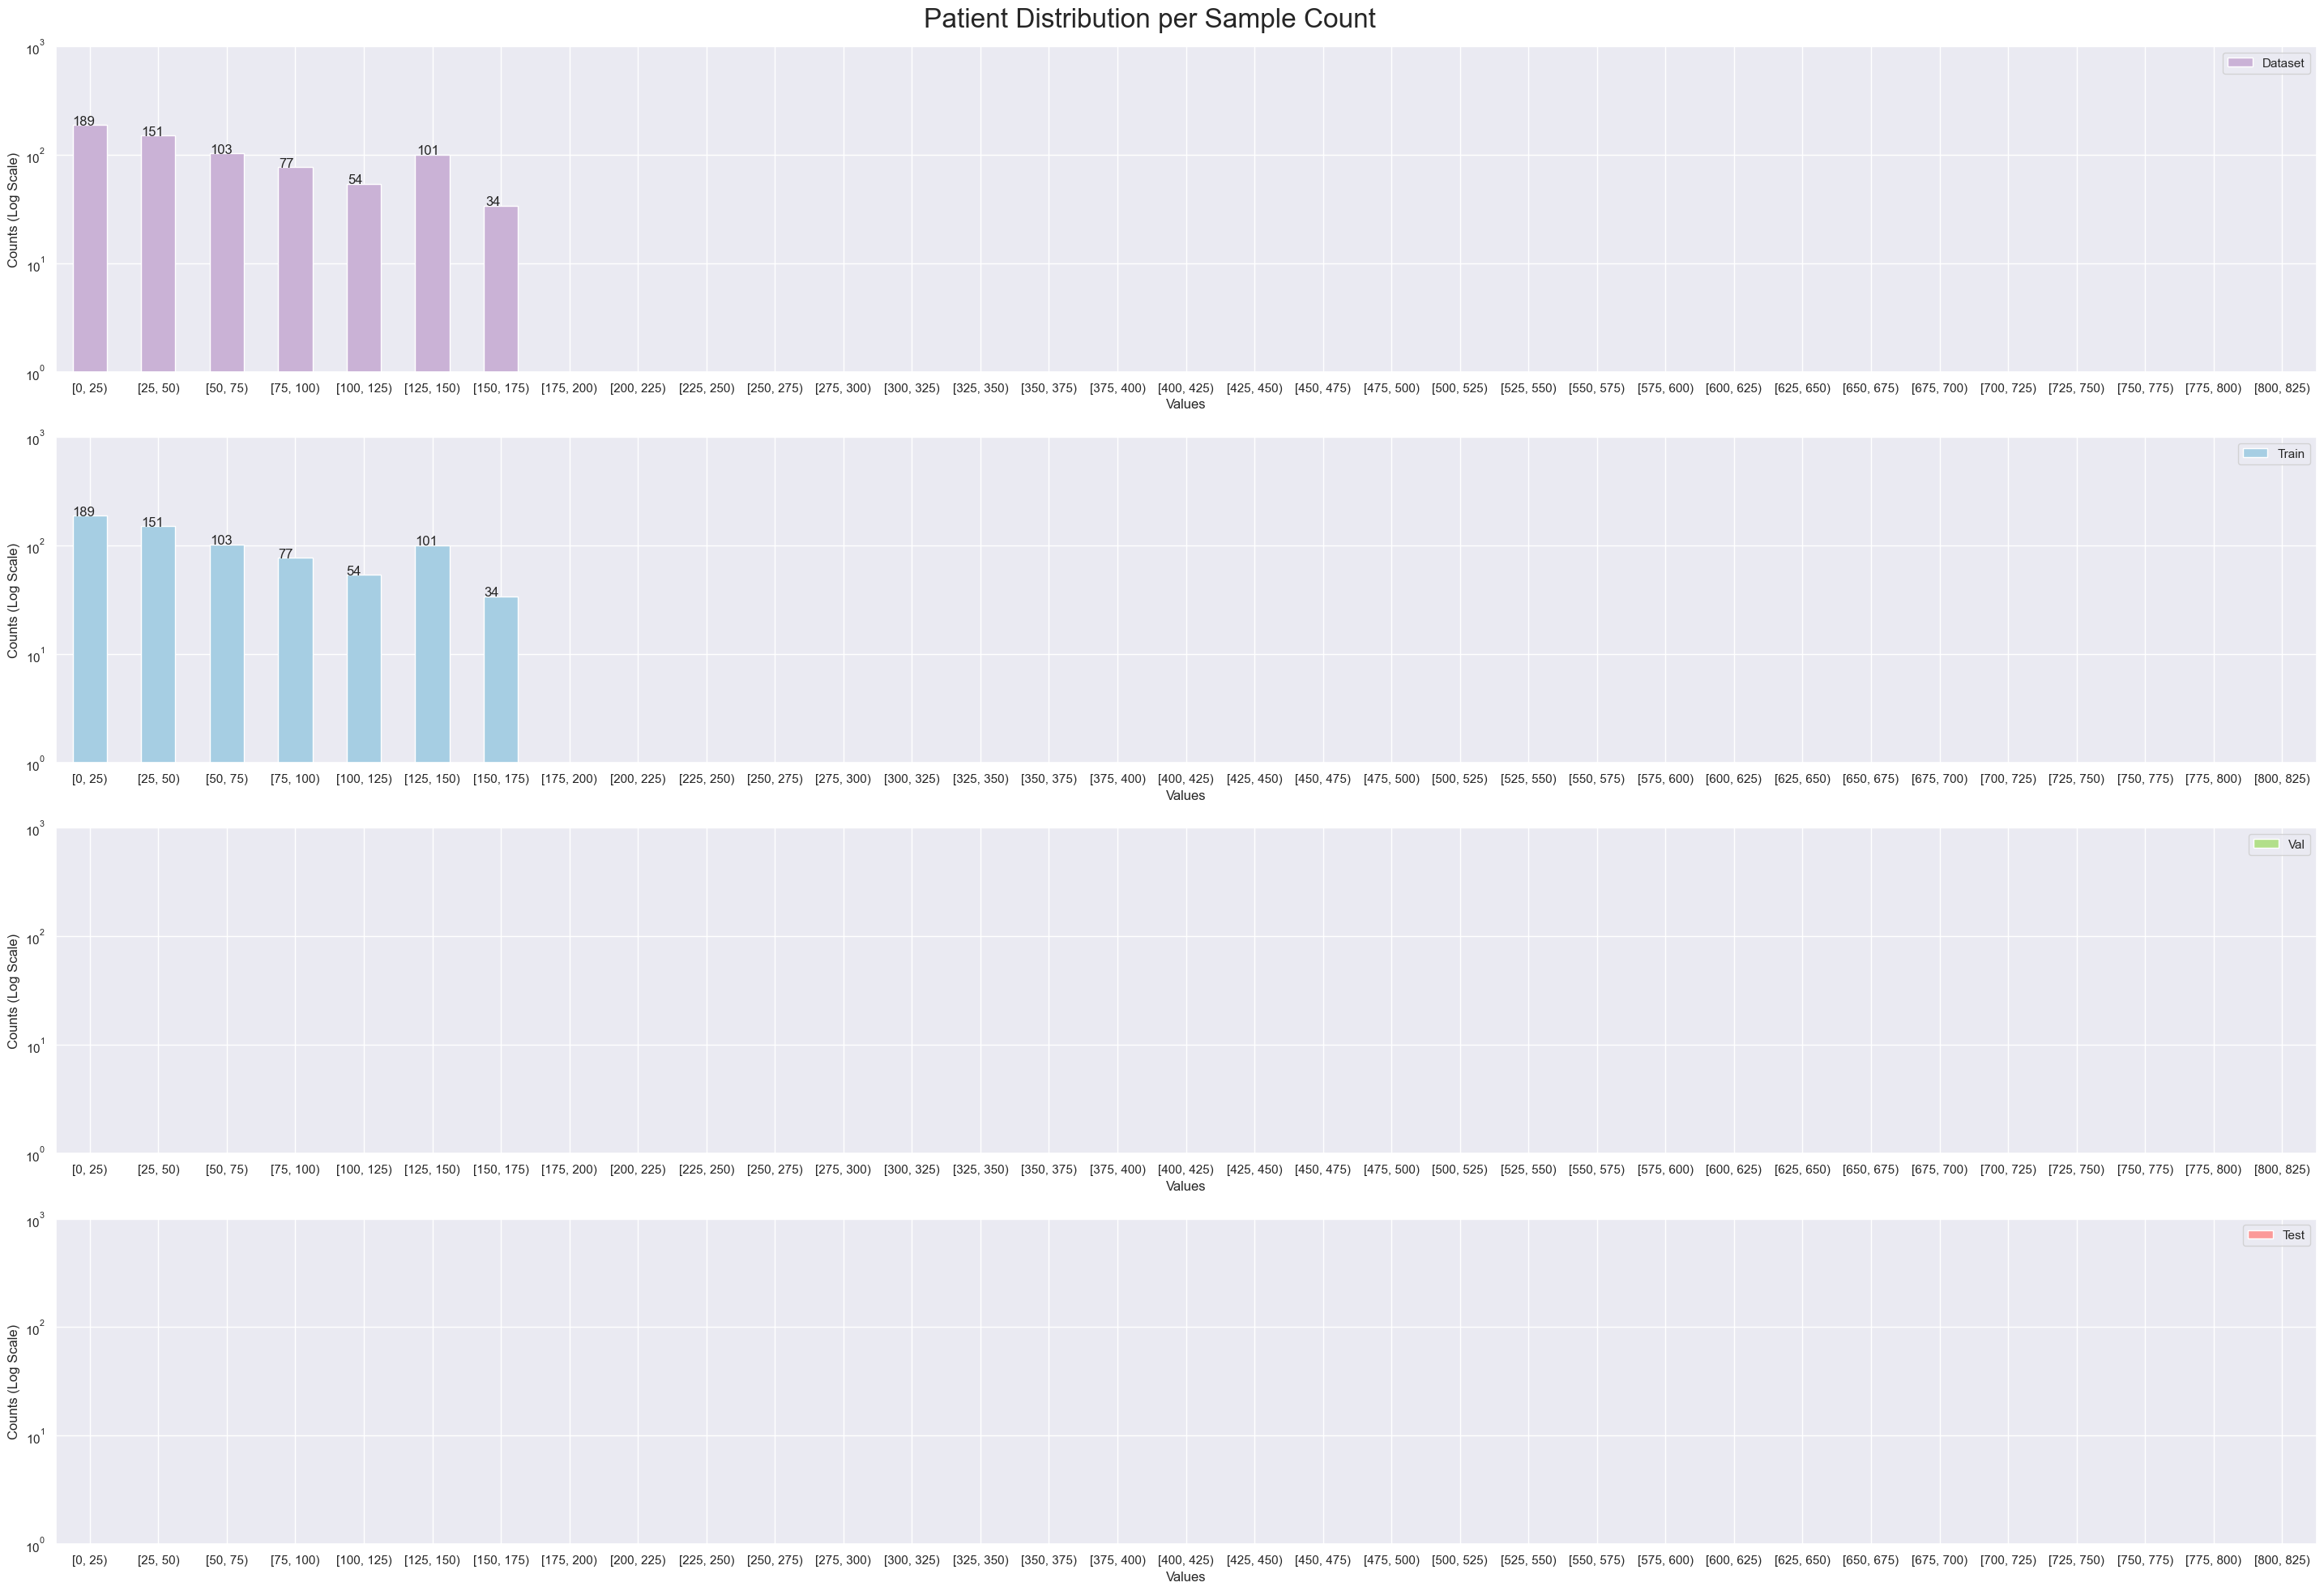

In [5]:
figure = plt.figure( figsize = (36, 24) )
plot.column_per_partition_as_histogram( patient_df, "sample_count", dataset_name, figure, title_complement = "Patient")

In [6]:
counts_df = plot.column_bins_per_partition_as_df( patient_df, "sample_count", dataset_name )
counts_df.head(len(counts_df))

Dataset  Train  Val  Test
Values                               
[0, 25)         189    189    0     0
[25, 50)        151    151    0     0
[50, 75)        103    103    0     0
[75, 100)        77     77    0     0
[100, 125)       54     54    0     0
[125, 150)      101    101    0     0
[150, 175)       34     34    0     0
[175, 200)        0      0    0     0
[200, 225)        0      0    0     0
[225, 250)        0      0    0     0
[250, 275)        0      0    0     0
[275, 300)        0      0    0     0
[300, 325)        0      0    0     0
[325, 350)        0      0    0     0
[350, 375)        0      0    0     0
[375, 400)        0      0    0     0
[400, 425)        0      0    0     0
[425, 450)        0      0    0     0
[450, 475)        0      0    0     0
[475, 500)        0      0    0     0
[500, 525)        0      0    0     0
[525, 550)        0      0    0     0
[550, 575)        0      0    0     0
[575, 600)        0      0    0     0
[600, 625)        0      0    0     0
[625, 650)        0      0    0     0
[650, 675)        0      0    0     0
[675, 700)        0      0    0     0
[700, 725)        0      0    0     0
[725, 750)        0      0    0     0
[750, 775)        0      0    0     0
[775, 800)        0      0    0     0
[800, 825)        0      0    0     0
SUM             709    709    0     0

# Plots

## Class

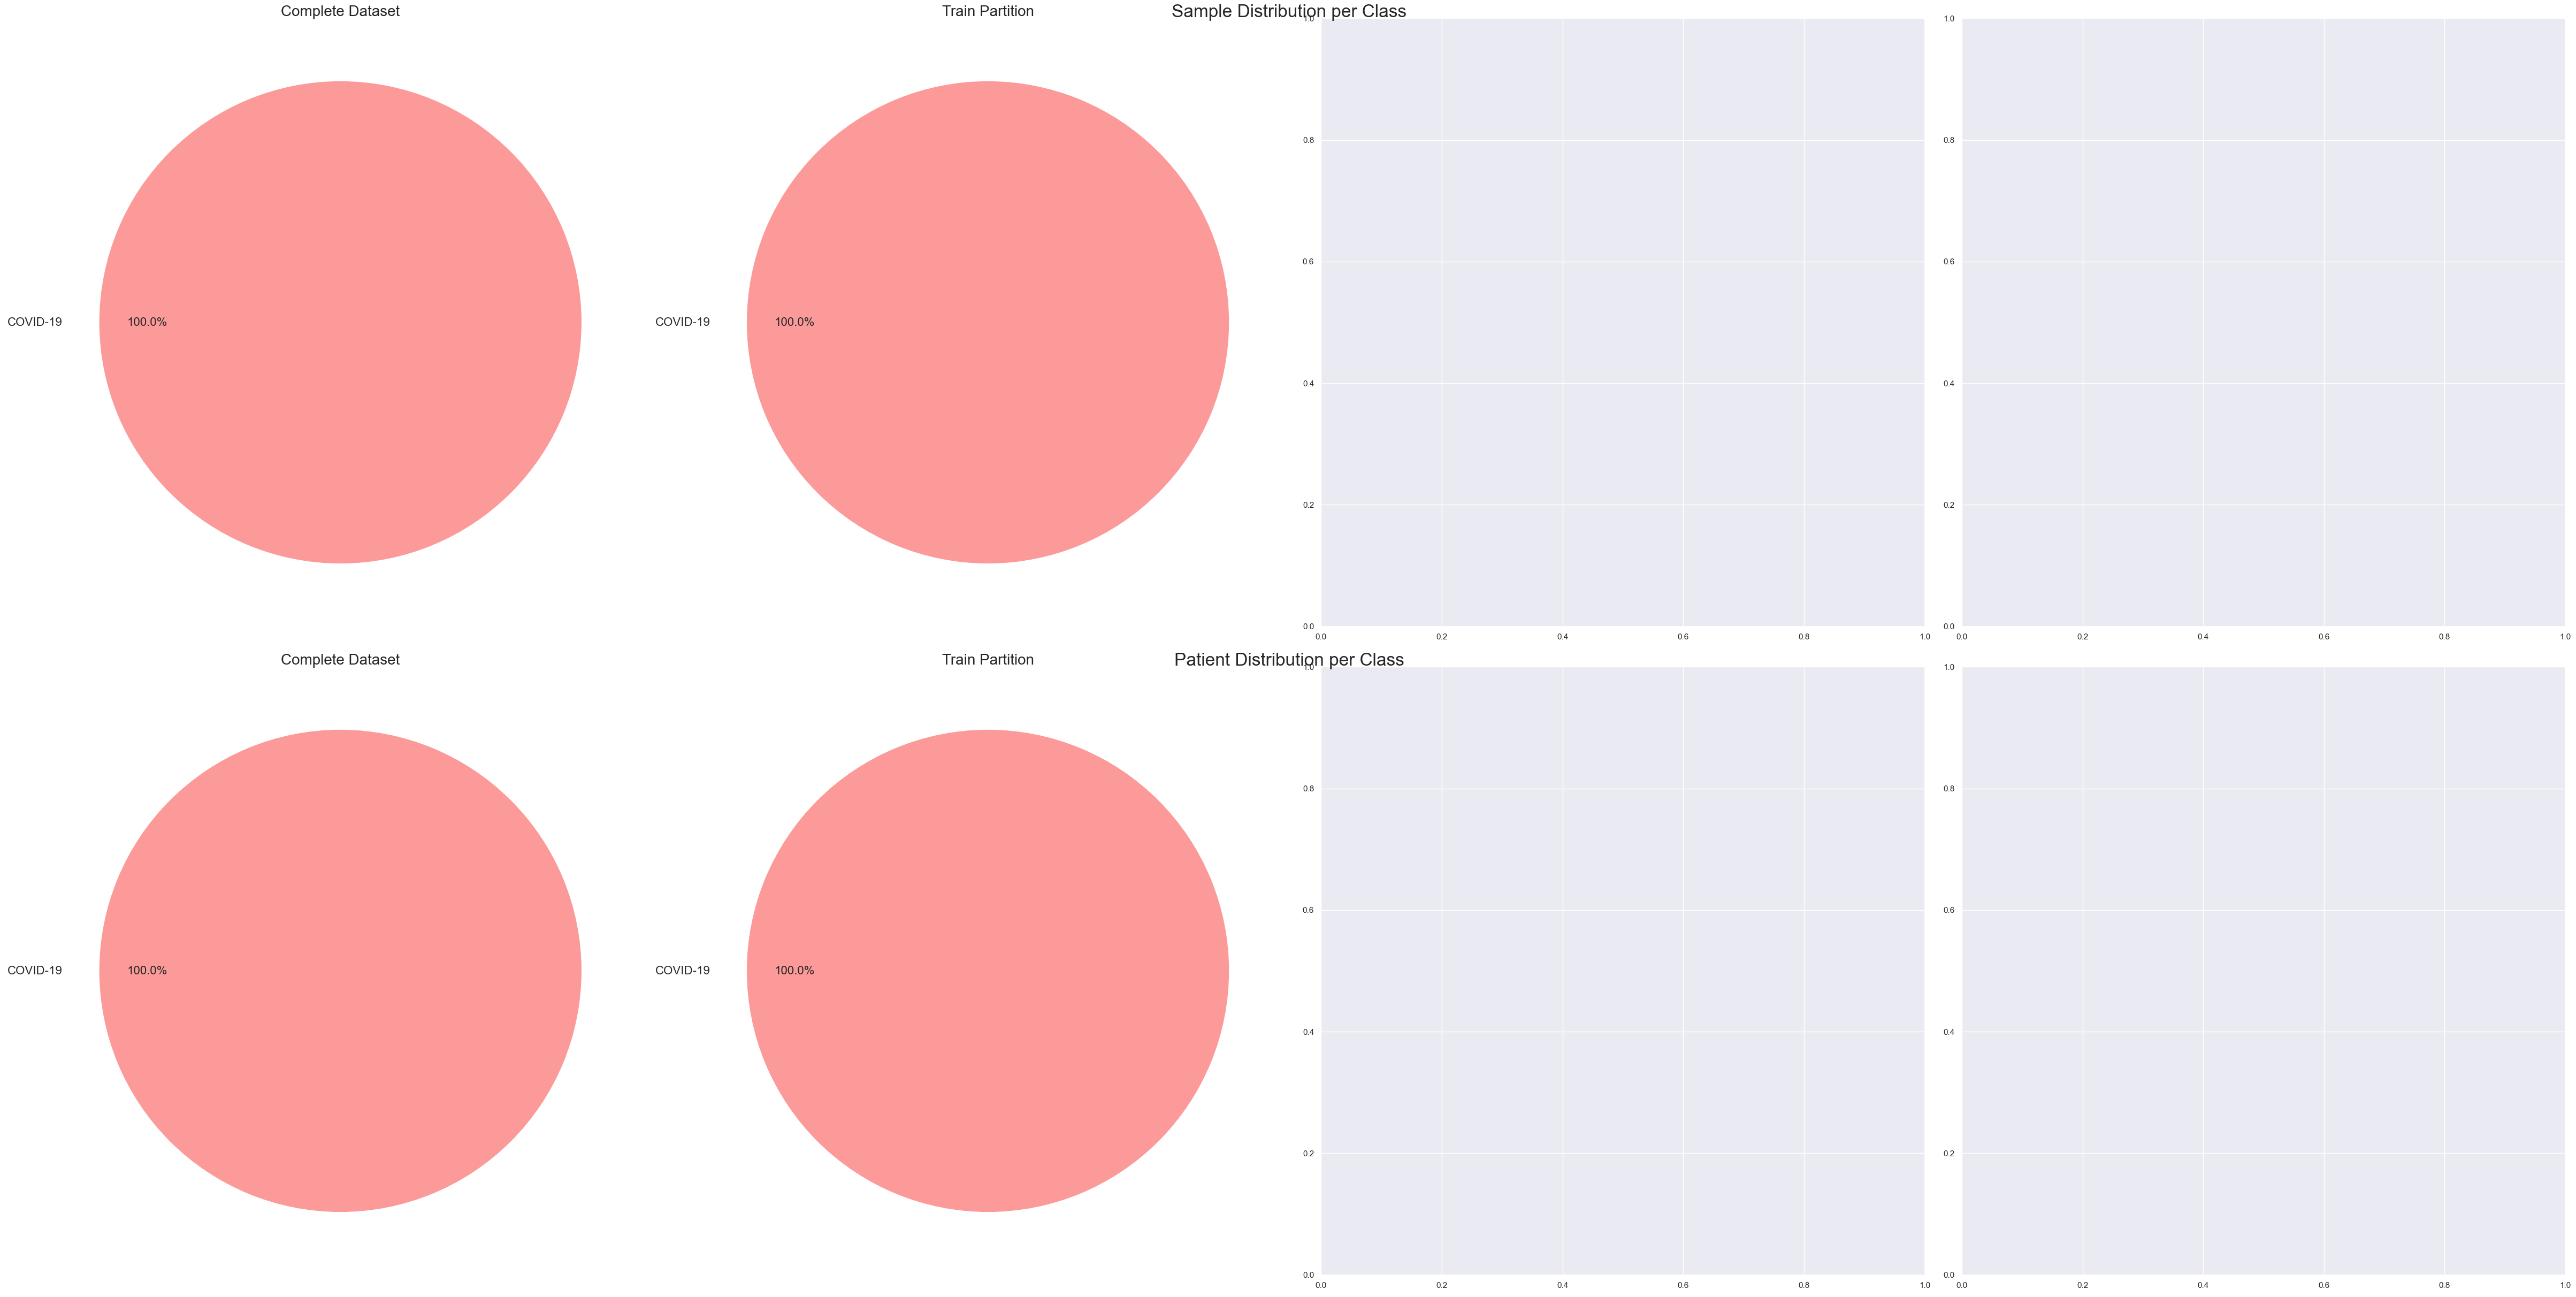

In [7]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [8]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

Sample Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 45912 
 45912 
 0 
 0 
 
 
 Normal 
 0 
 0 
 0 
 0 
 
 
 Pneumonia 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 709 
 709 
 0 
 0 
 
 
 Pneumonia 
 0 
 0 
 0 
 0 
 
 
 Normal 
 0 
 0 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

## Age

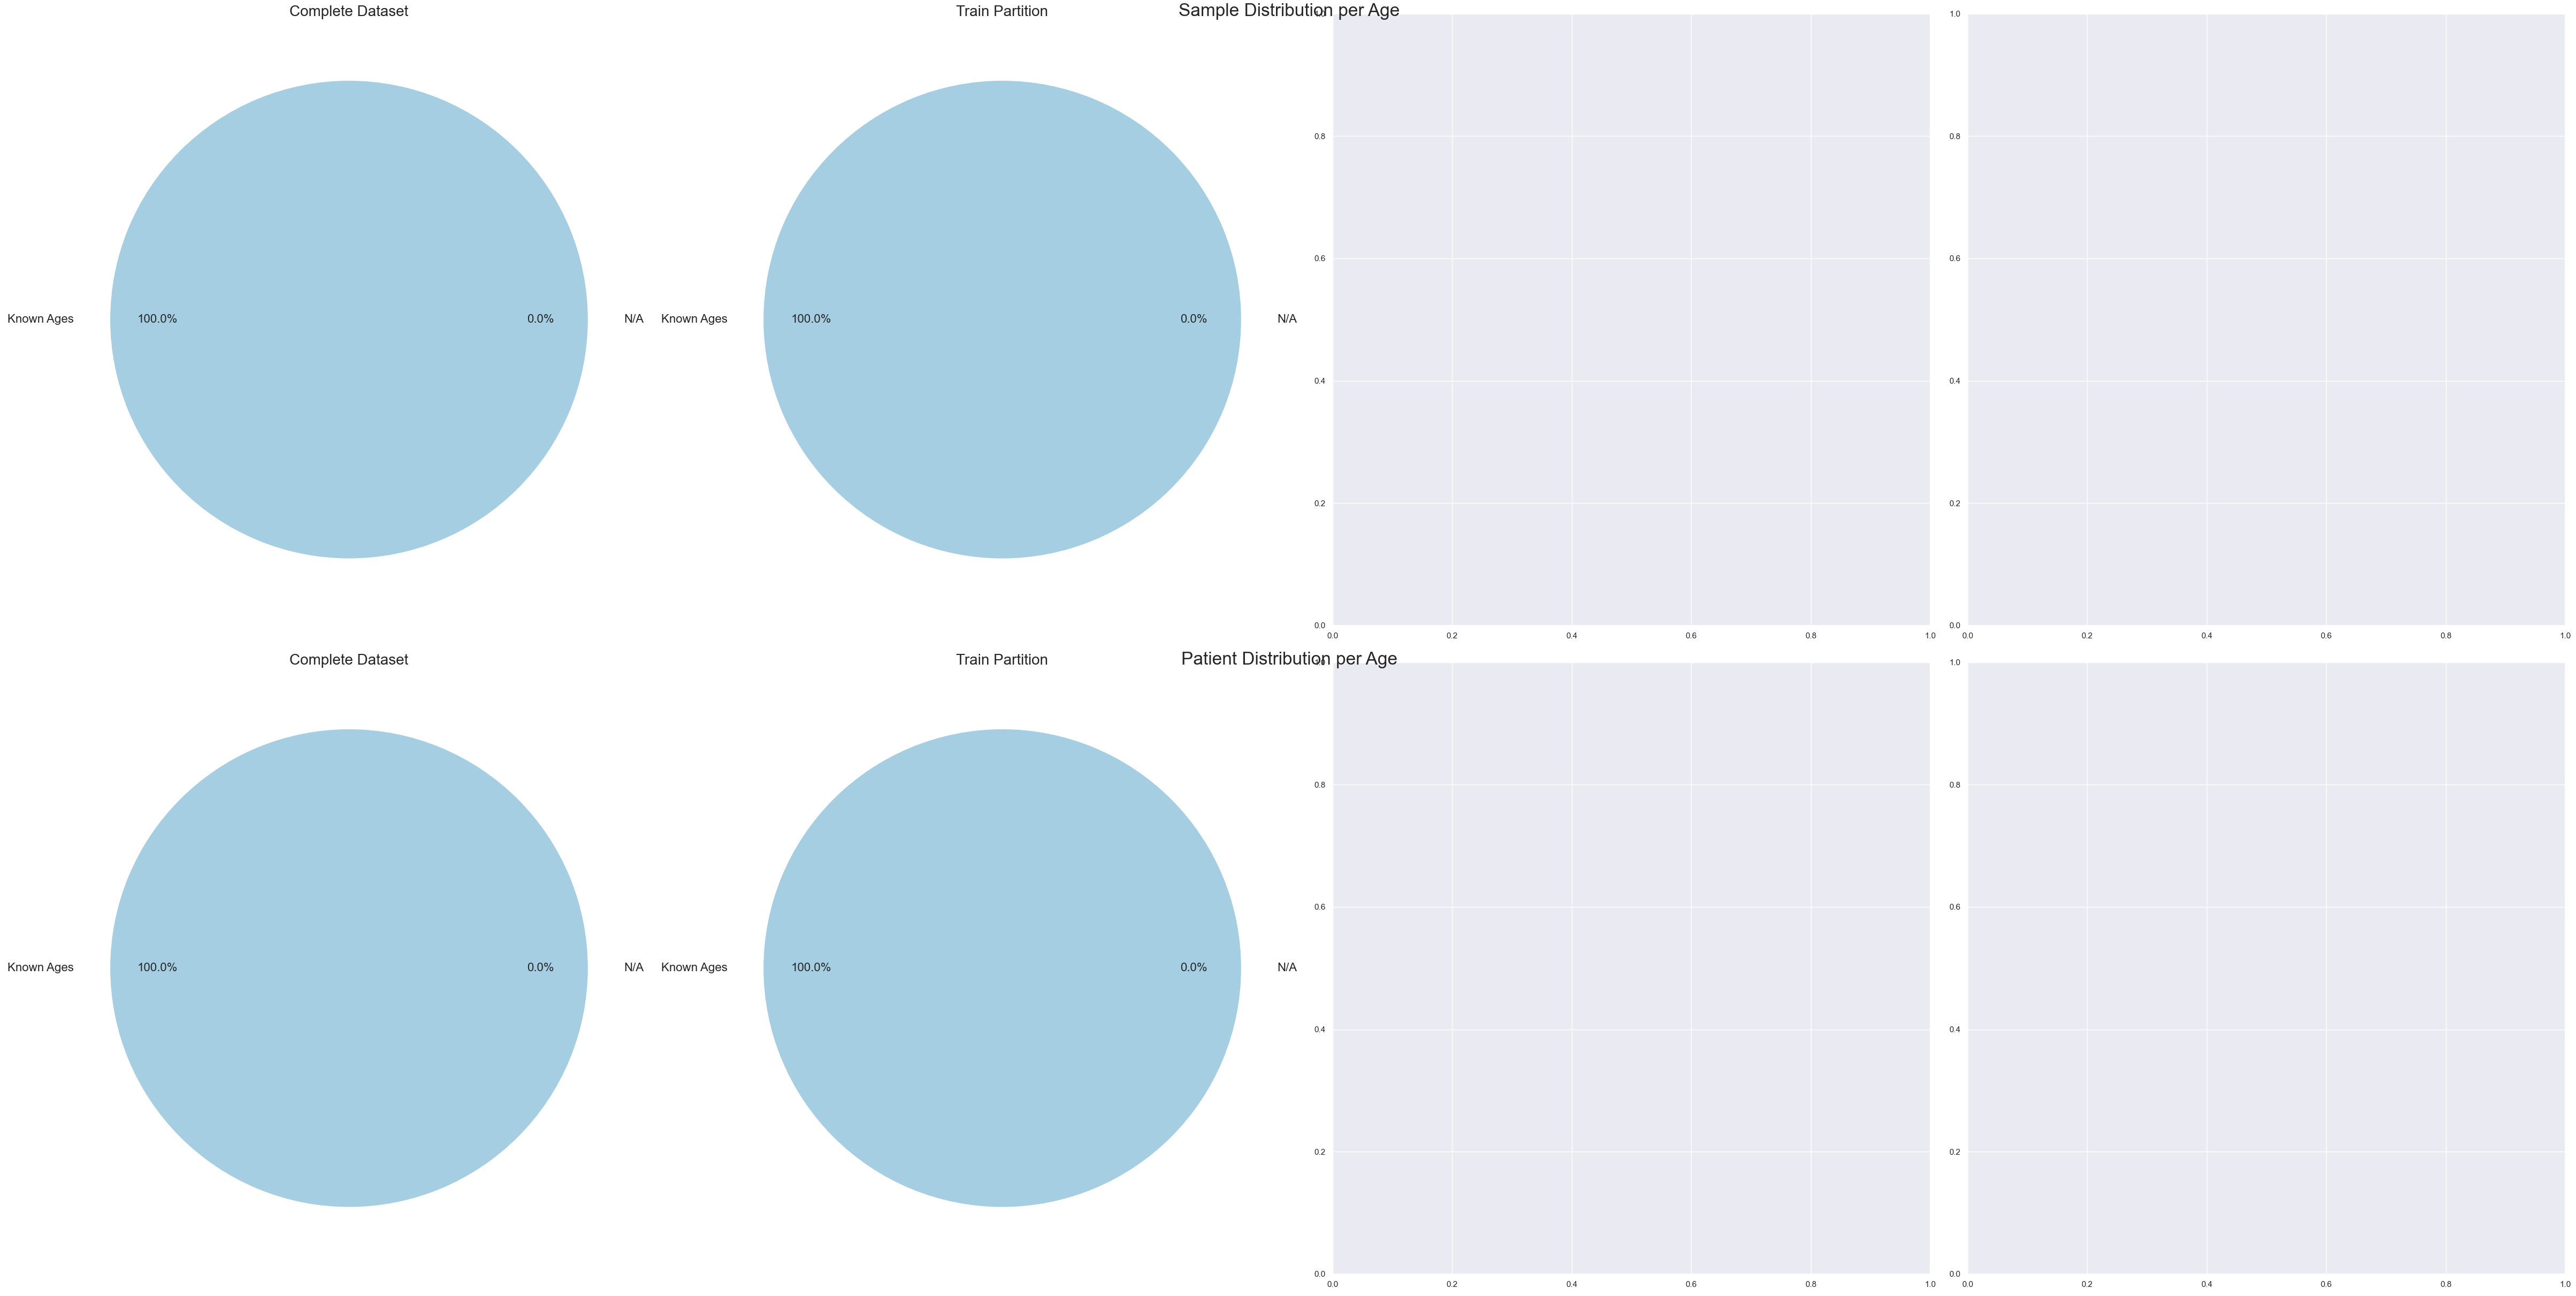

In [9]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [10]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Known Ages 
 45912 
 45912 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Known Ages 
 709 
 709 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

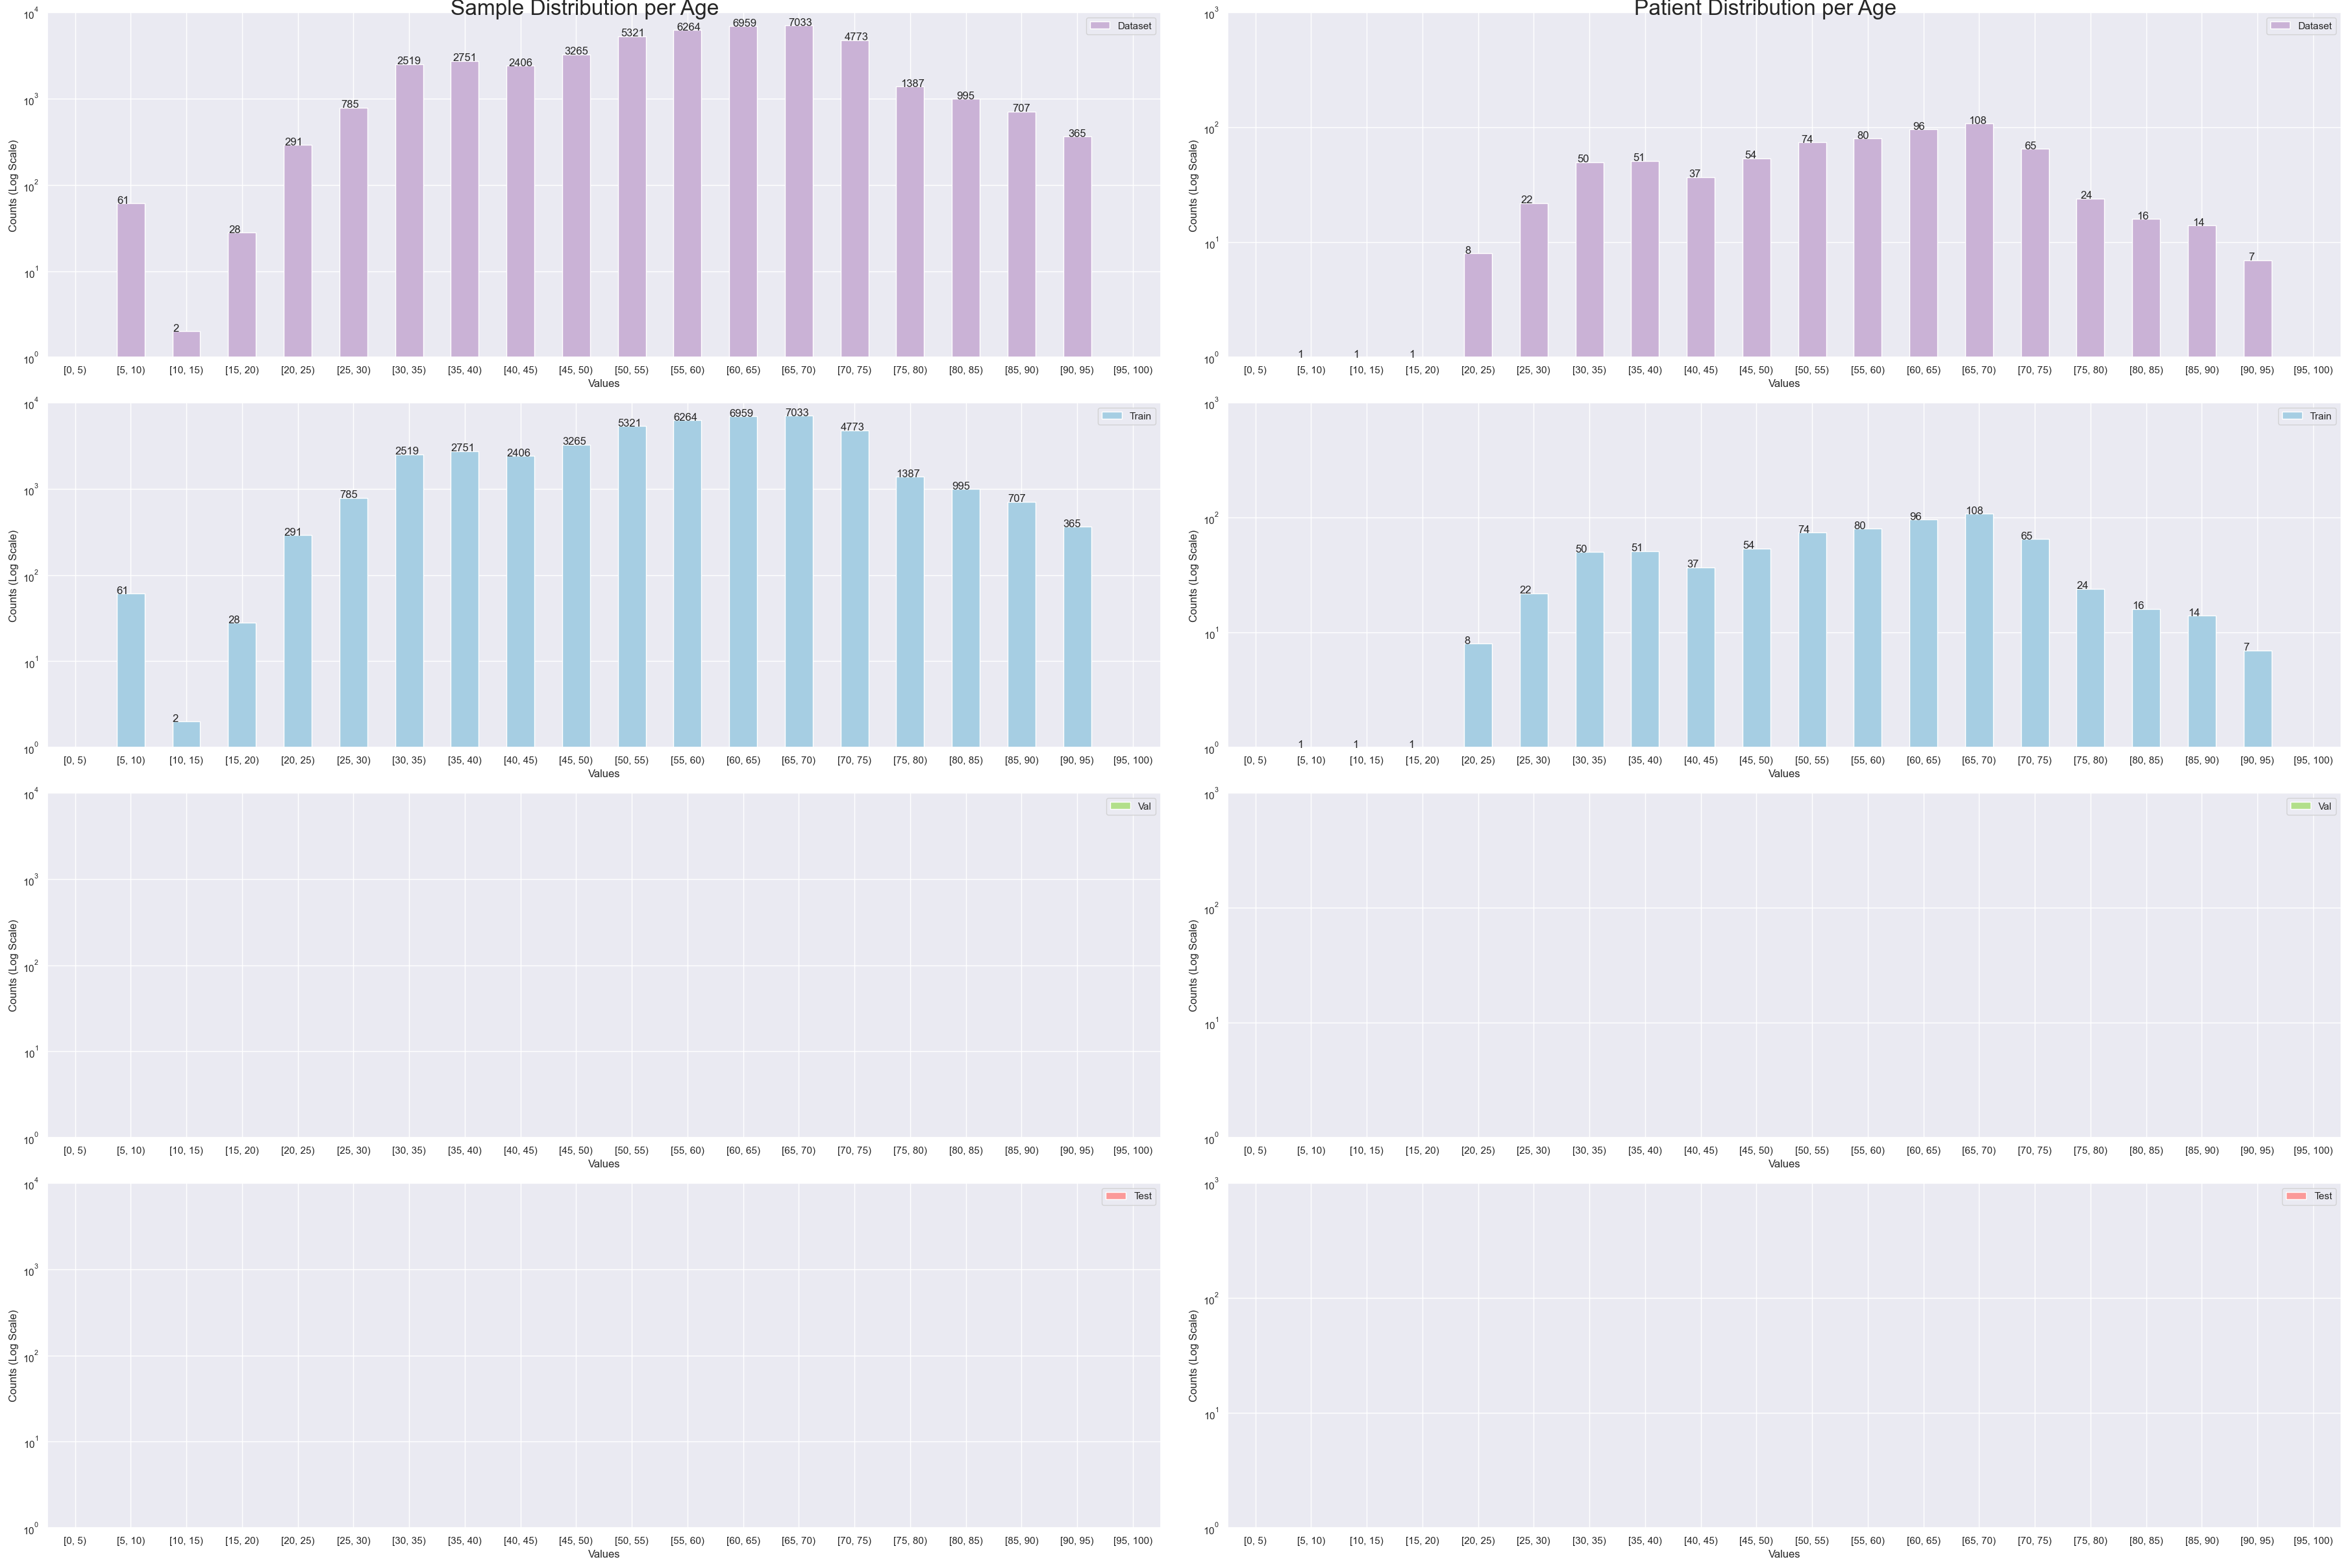

In [11]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [12]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 0 
 0 
 0 
 0 
 
 
 [5, 10) 
 61 
 61 
 0 
 0 
 
 
 [10, 15) 
 2 
 2 
 0 
 0 
 
 
 [15, 20) 
 28 
 28 
 0 
 0 
 
 
 [20, 25) 
 291 
 291 
 0 
 0 
 
 
 [25, 30) 
 785 
 785 
 0 
 0 
 
 
 [30, 35) 
 2519 
 2519 
 0 
 0 
 
 
 [35, 40) 
 2751 
 2751 
 0 
 0 
 
 
 [40, 45) 
 2406 
 2406 
 0 
 0 
 
 
 [45, 50) 
 3265 
 3265 
 0 
 0 
 
 
 [50, 55) 
 5321 
 5321 
 0 
 0 
 
 
 [55, 60) 
 6264 
 6264 
 0 
 0 
 
 
 [60, 65) 
 6959 
 6959 
 0 
 0 
 
 
 [65, 70) 
 7033 
 7033 
 0 
 0 
 
 
 [70, 75) 
 4773 
 4773 
 0 
 0 
 
 
 [75, 80) 
 1387 
 1387 
 0 
 0 
 
 
 [80, 85) 
 995 
 995 
 0 
 0 
 
 
 [85, 90) 
 707 
 707 
 0 
 0 
 
 
 [90, 95) 
 365 
 365 
 0 
 0 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 0 
 0 
 0 
 0 
 
 
 [5, 10) 
 1 
 1 
 0 
 0 
 
 
 [10, 15) 
 1 
 1 
 0 
 0 
 
 
 [15, 20) 
 1 
 1 
 0 
 0 
 
 
 [20, 25) 
 8 
 8 
 0 
 0 
 
 
 [25, 30) 
 22 
 22 
 0 
 0 
 
 
 [30, 35) 
 50 
 50 
 0 
 0 
 
 
 [35, 40) 
 51 
 51 
 0 
 0 
 
 
 [40, 45) 
 37 
 37 
 0 
 0 
 
 
 [45, 50) 
 54 
 54 
 0 
 0 
 
 
 [50, 55) 
 74 
 74 
 0 
 0 
 
 
 [55, 60) 
 80 
 80 
 0 
 0 
 
 
 [60, 65) 
 96 
 96 
 0 
 0 
 
 
 [65, 70) 
 108 
 108 
 0 
 0 
 
 
 [70, 75) 
 65 
 65 
 0 
 0 
 
 
 [75, 80) 
 24 
 24 
 0 
 0 
 
 
 [80, 85) 
 16 
 16 
 0 
 0 
 
 
 [85, 90) 
 14 
 14 
 0 
 0 
 
 
 [90, 95) 
 7 
 7 
 0 
 0 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

## Sex

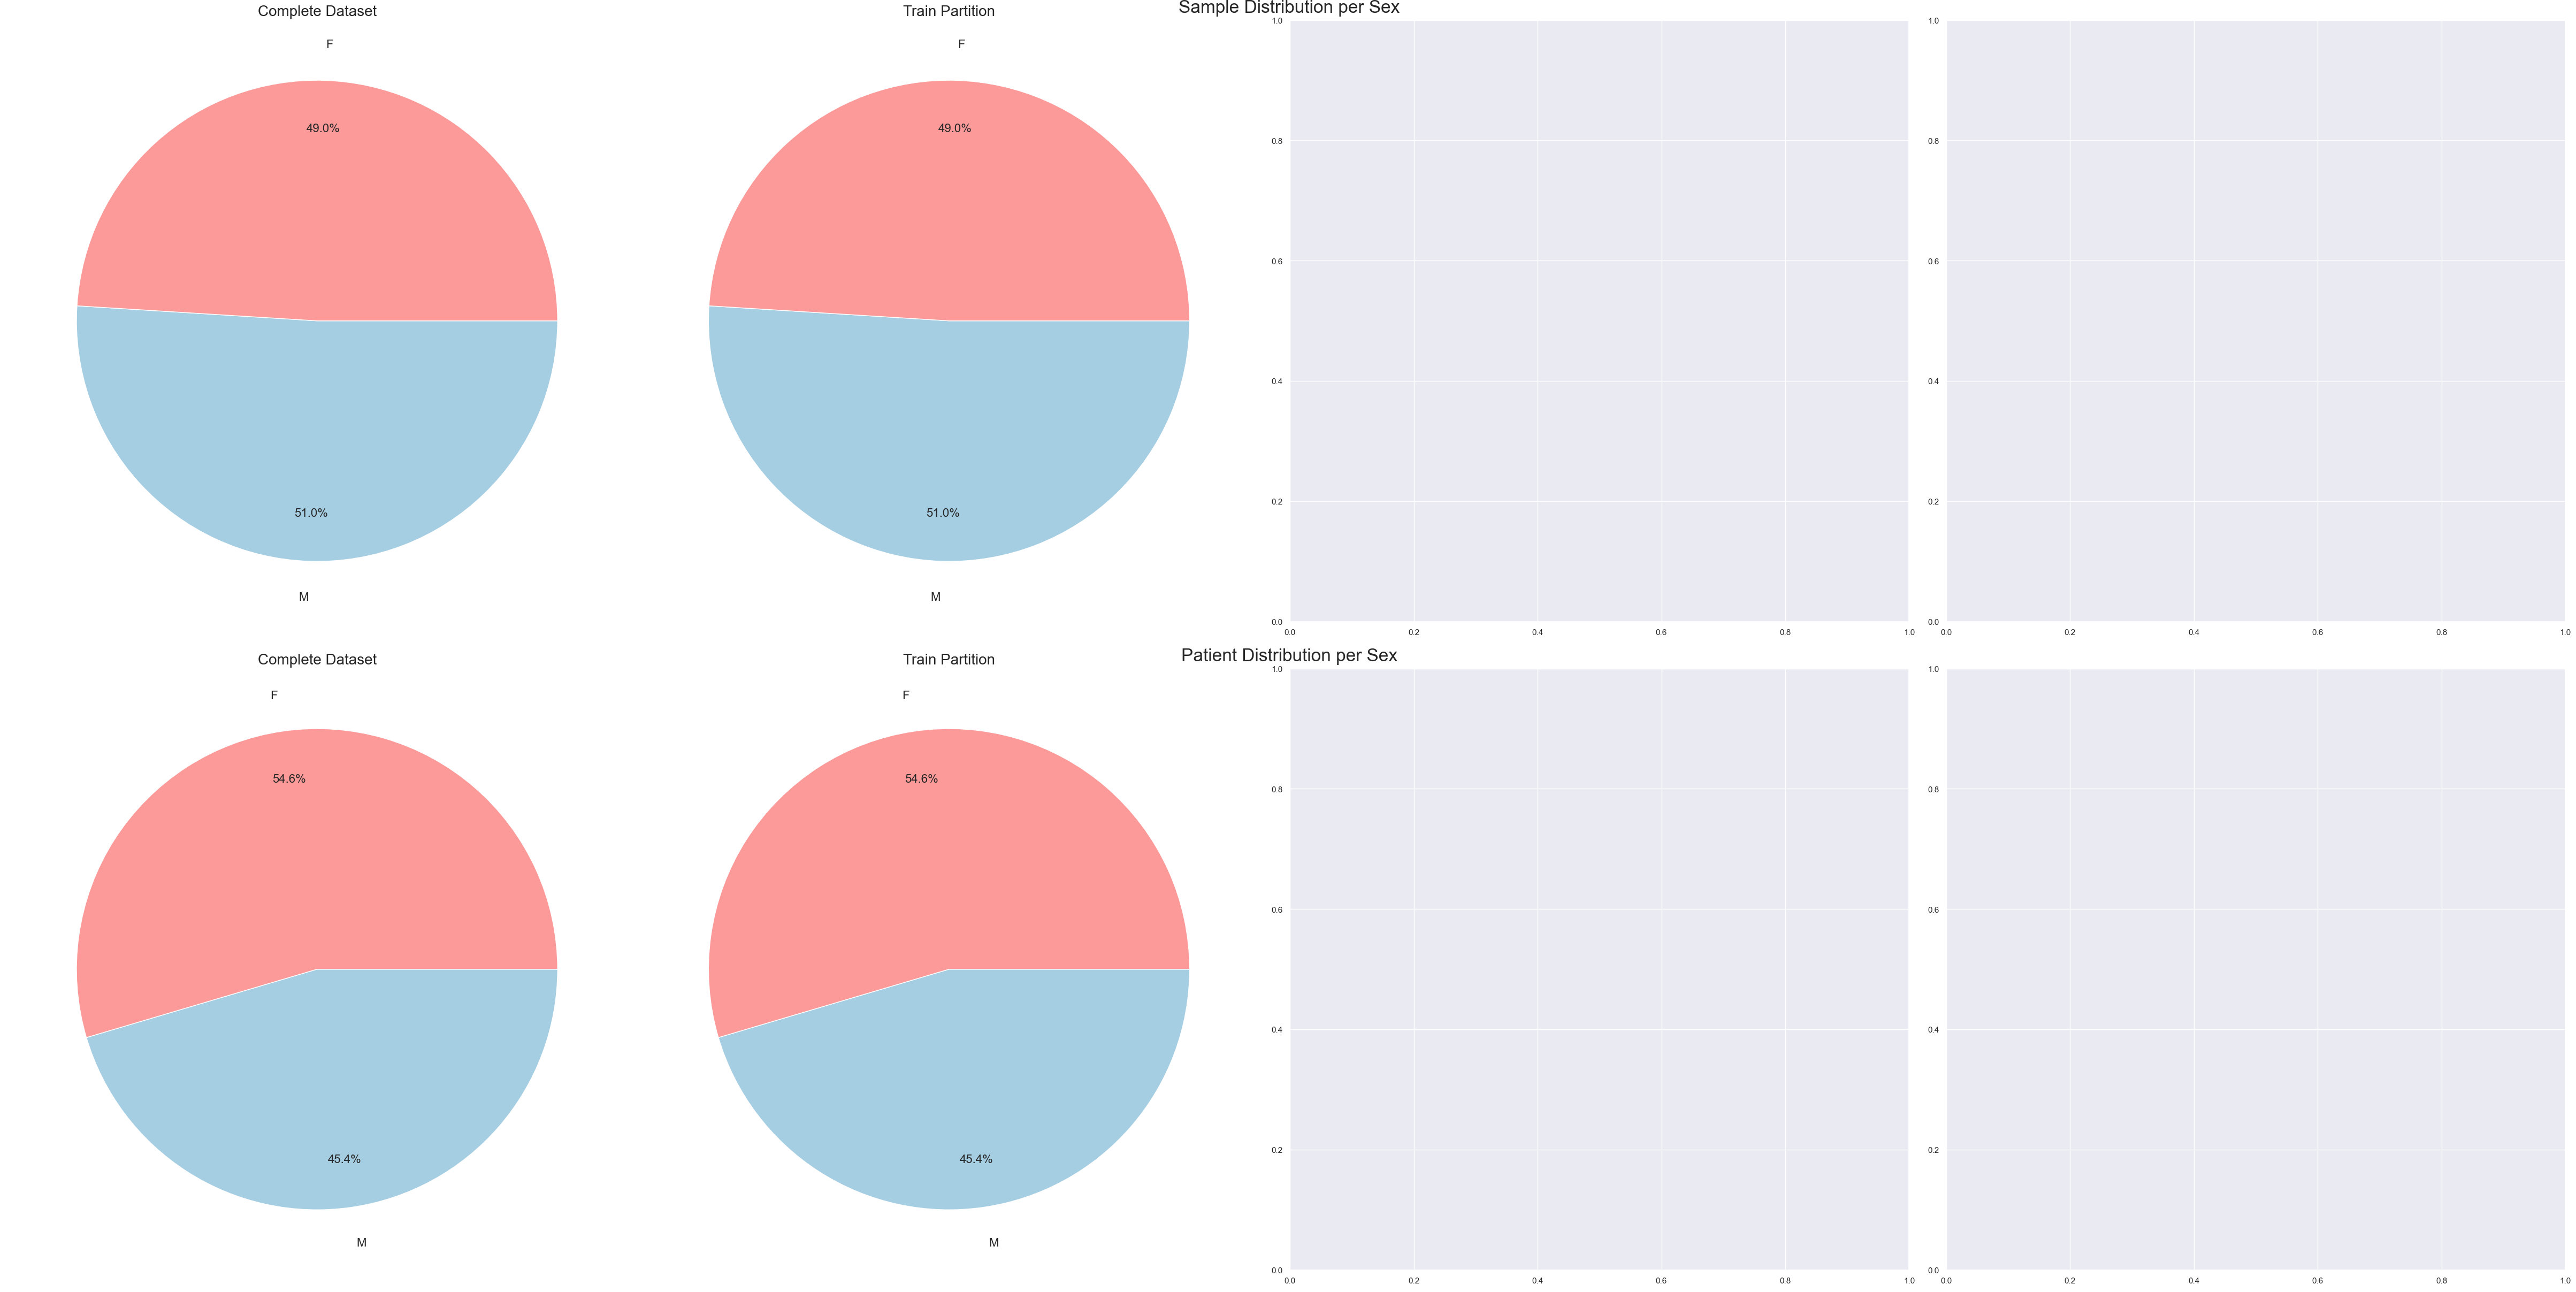

In [13]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [14]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

Sample Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 M 
 23412 
 23412 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 F 
 22500 
 22500 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 M 
 322 
 322 
 0 
 0 
 
 
 F 
 387 
 387 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

## Country

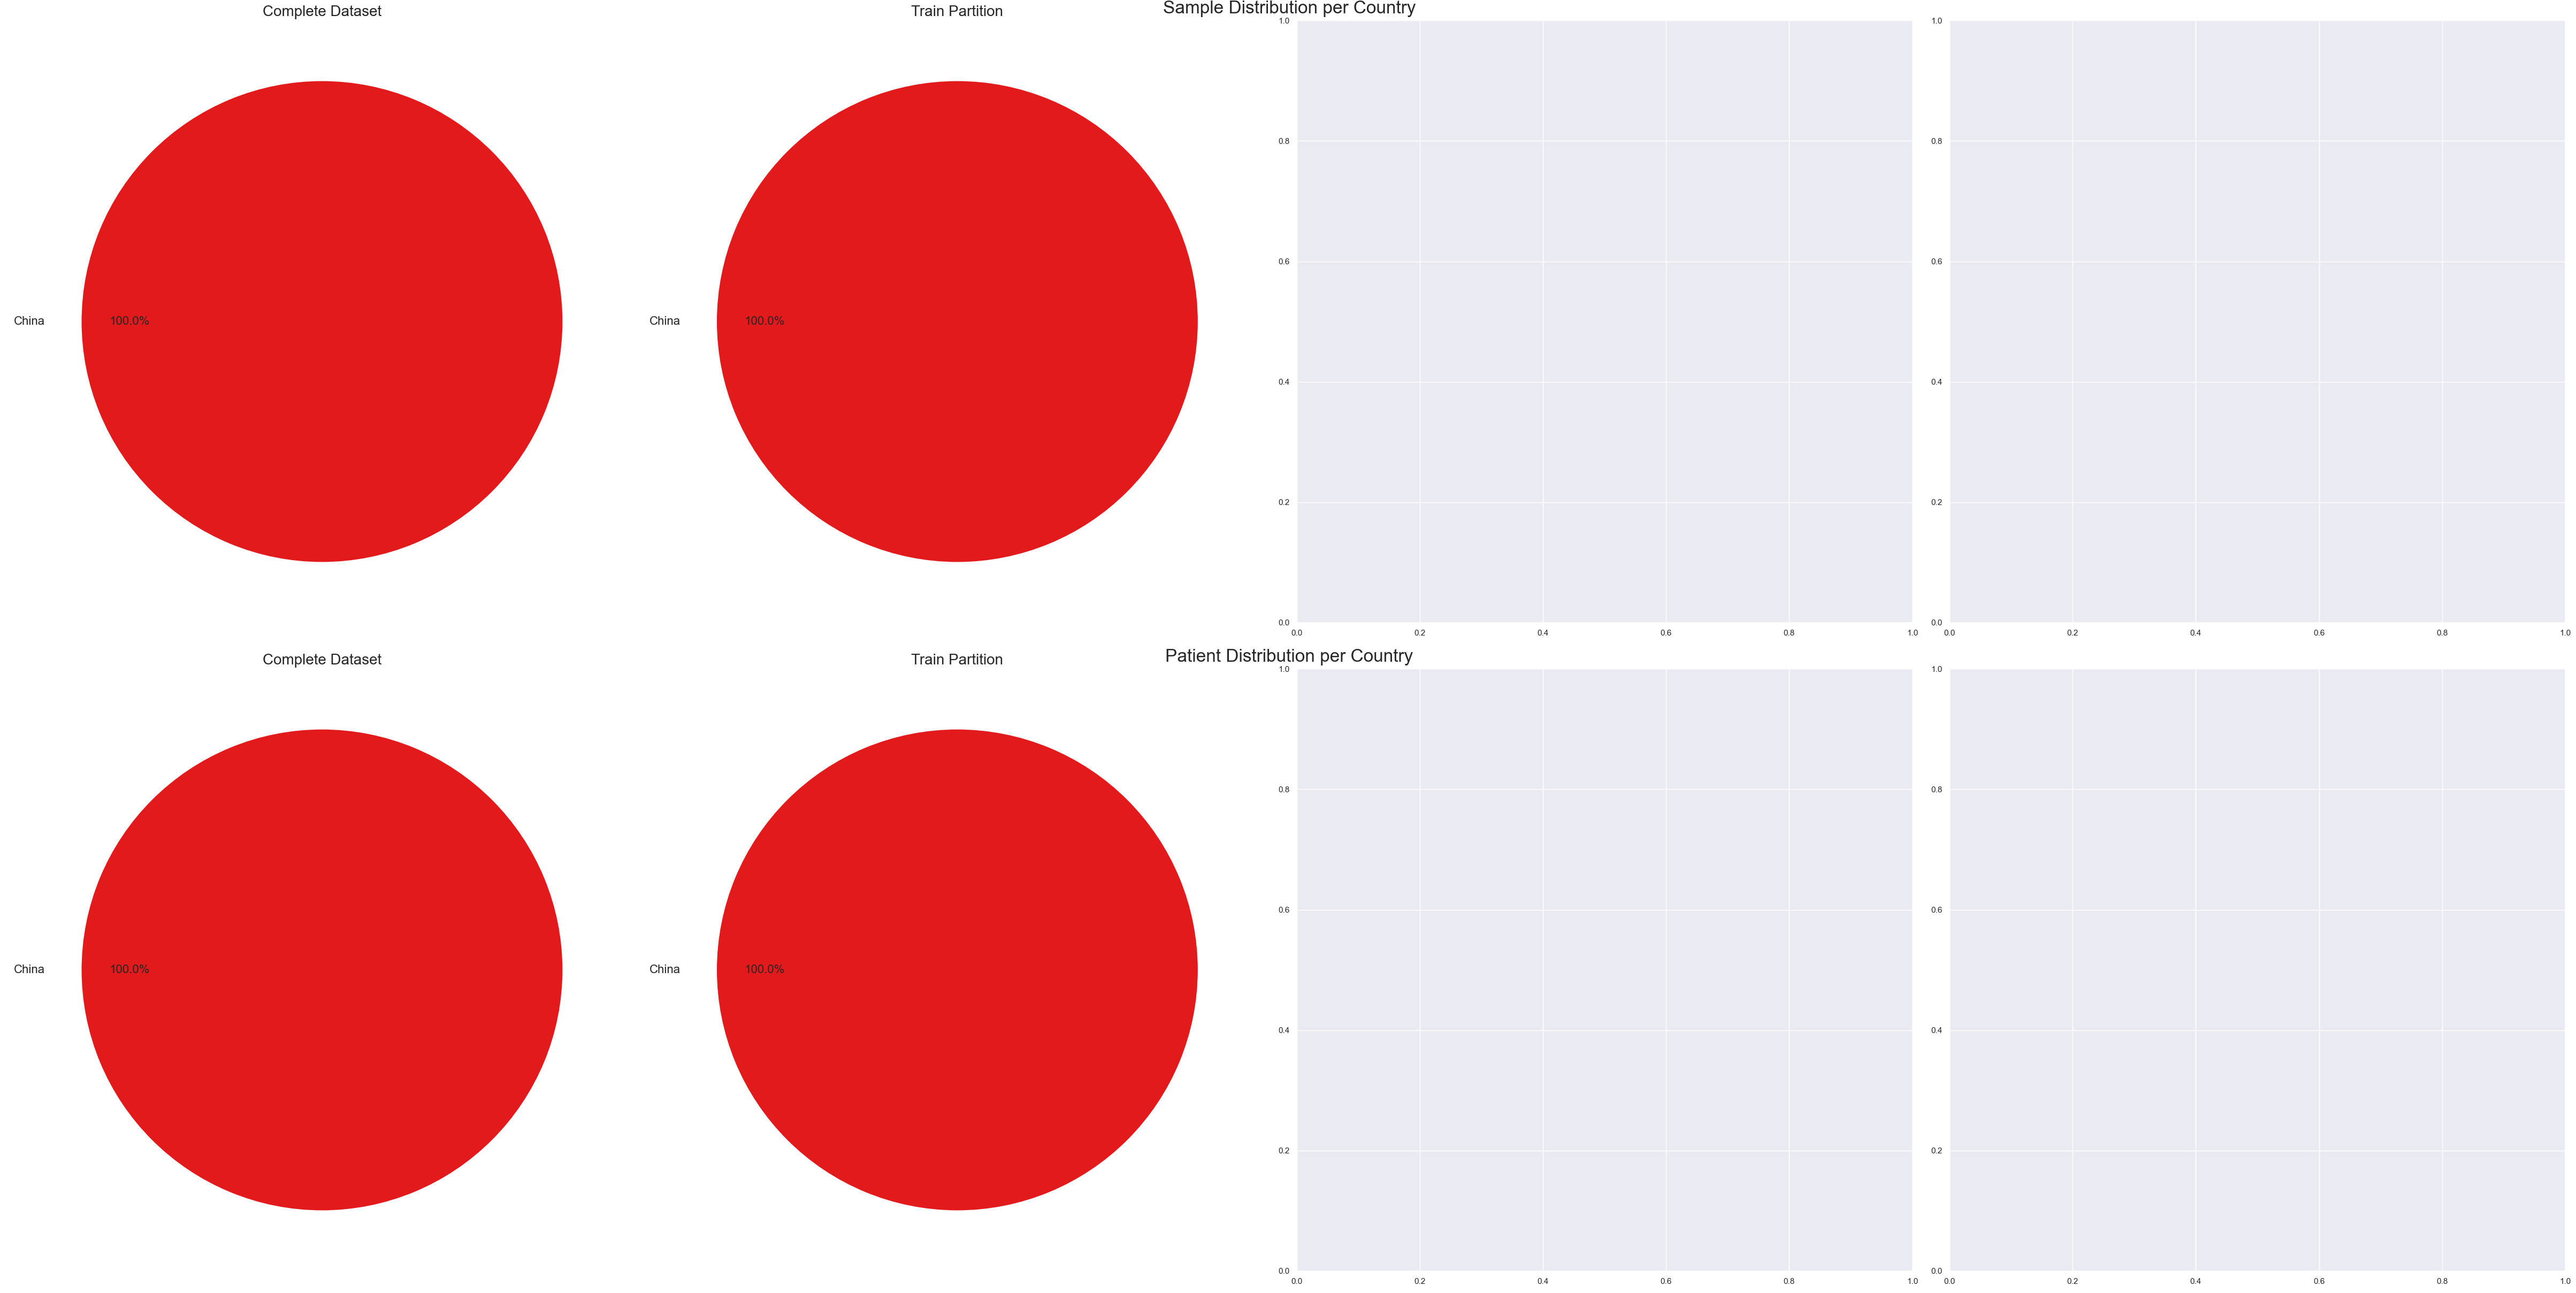

In [15]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [16]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

Sample Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 France 
 0 
 0 
 0 
 0 
 
 
 China 
 45912 
 45912 
 0 
 0 
 
 
 Iran 
 0 
 0 
 0 
 0 
 
 
 USA 
 0 
 0 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Australia 
 0 
 0 
 0 
 0 
 
 
 Italy 
 0 
 0 
 0 
 0 
 
 
 Algeria 
 0 
 0 
 0 
 0 
 
 
 Belgium 
 0 
 0 
 0 
 0 
 
 
 England 
 0 
 0 
 0 
 0 
 
 
 Scotland 
 0 
 0 
 0 
 0 
 
 
 Turkey 
 0 
 0 
 0 
 0 
 
 
 Azerbaijan 
 0 
 0 
 0 
 0 
 
 
 Lebanon 
 0 
 0 
 0 
 0 
 
 
 Ukraine 
 0 
 0 
 0 
 0 
 
 
 Afghanistan 
 0 
 0 
 0 
 0 
 
 
 Peru 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 709 
 709 
 0 
 0 
 
 
 France 
 0 
 0 
 0 
 0 
 
 
 Iran 
 0 
 0 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 USA 
 0 
 0 
 0 
 0 
 
 
 Australia 
 0 
 0 
 0 
 0 
 
 
 Algeria 
 0 
 0 
 0 
 0 
 
 
 Italy 
 0 
 0 
 0 
 0 
 
 
 Afghanistan 
 0 
 0 
 0 
 0 
 
 
 Azerbaijan 
 0 
 0 
 0 
 0 
 
 
 Belgium 
 0 
 0 
 0 
 0 
 
 
 England 
 0 
 0 
 0 
 0 
 
 
 Lebanon 
 0 
 0 
 0 
 0 
 
 
 Peru 
 0 
 0 
 0 
 0 
 
 
 Scotland 
 0 
 0 
 0 
 0 
 
 
 Turkey 
 0 
 0 
 0 
 0 
 
 
 Ukraine 
 0 
 0 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

## Partition

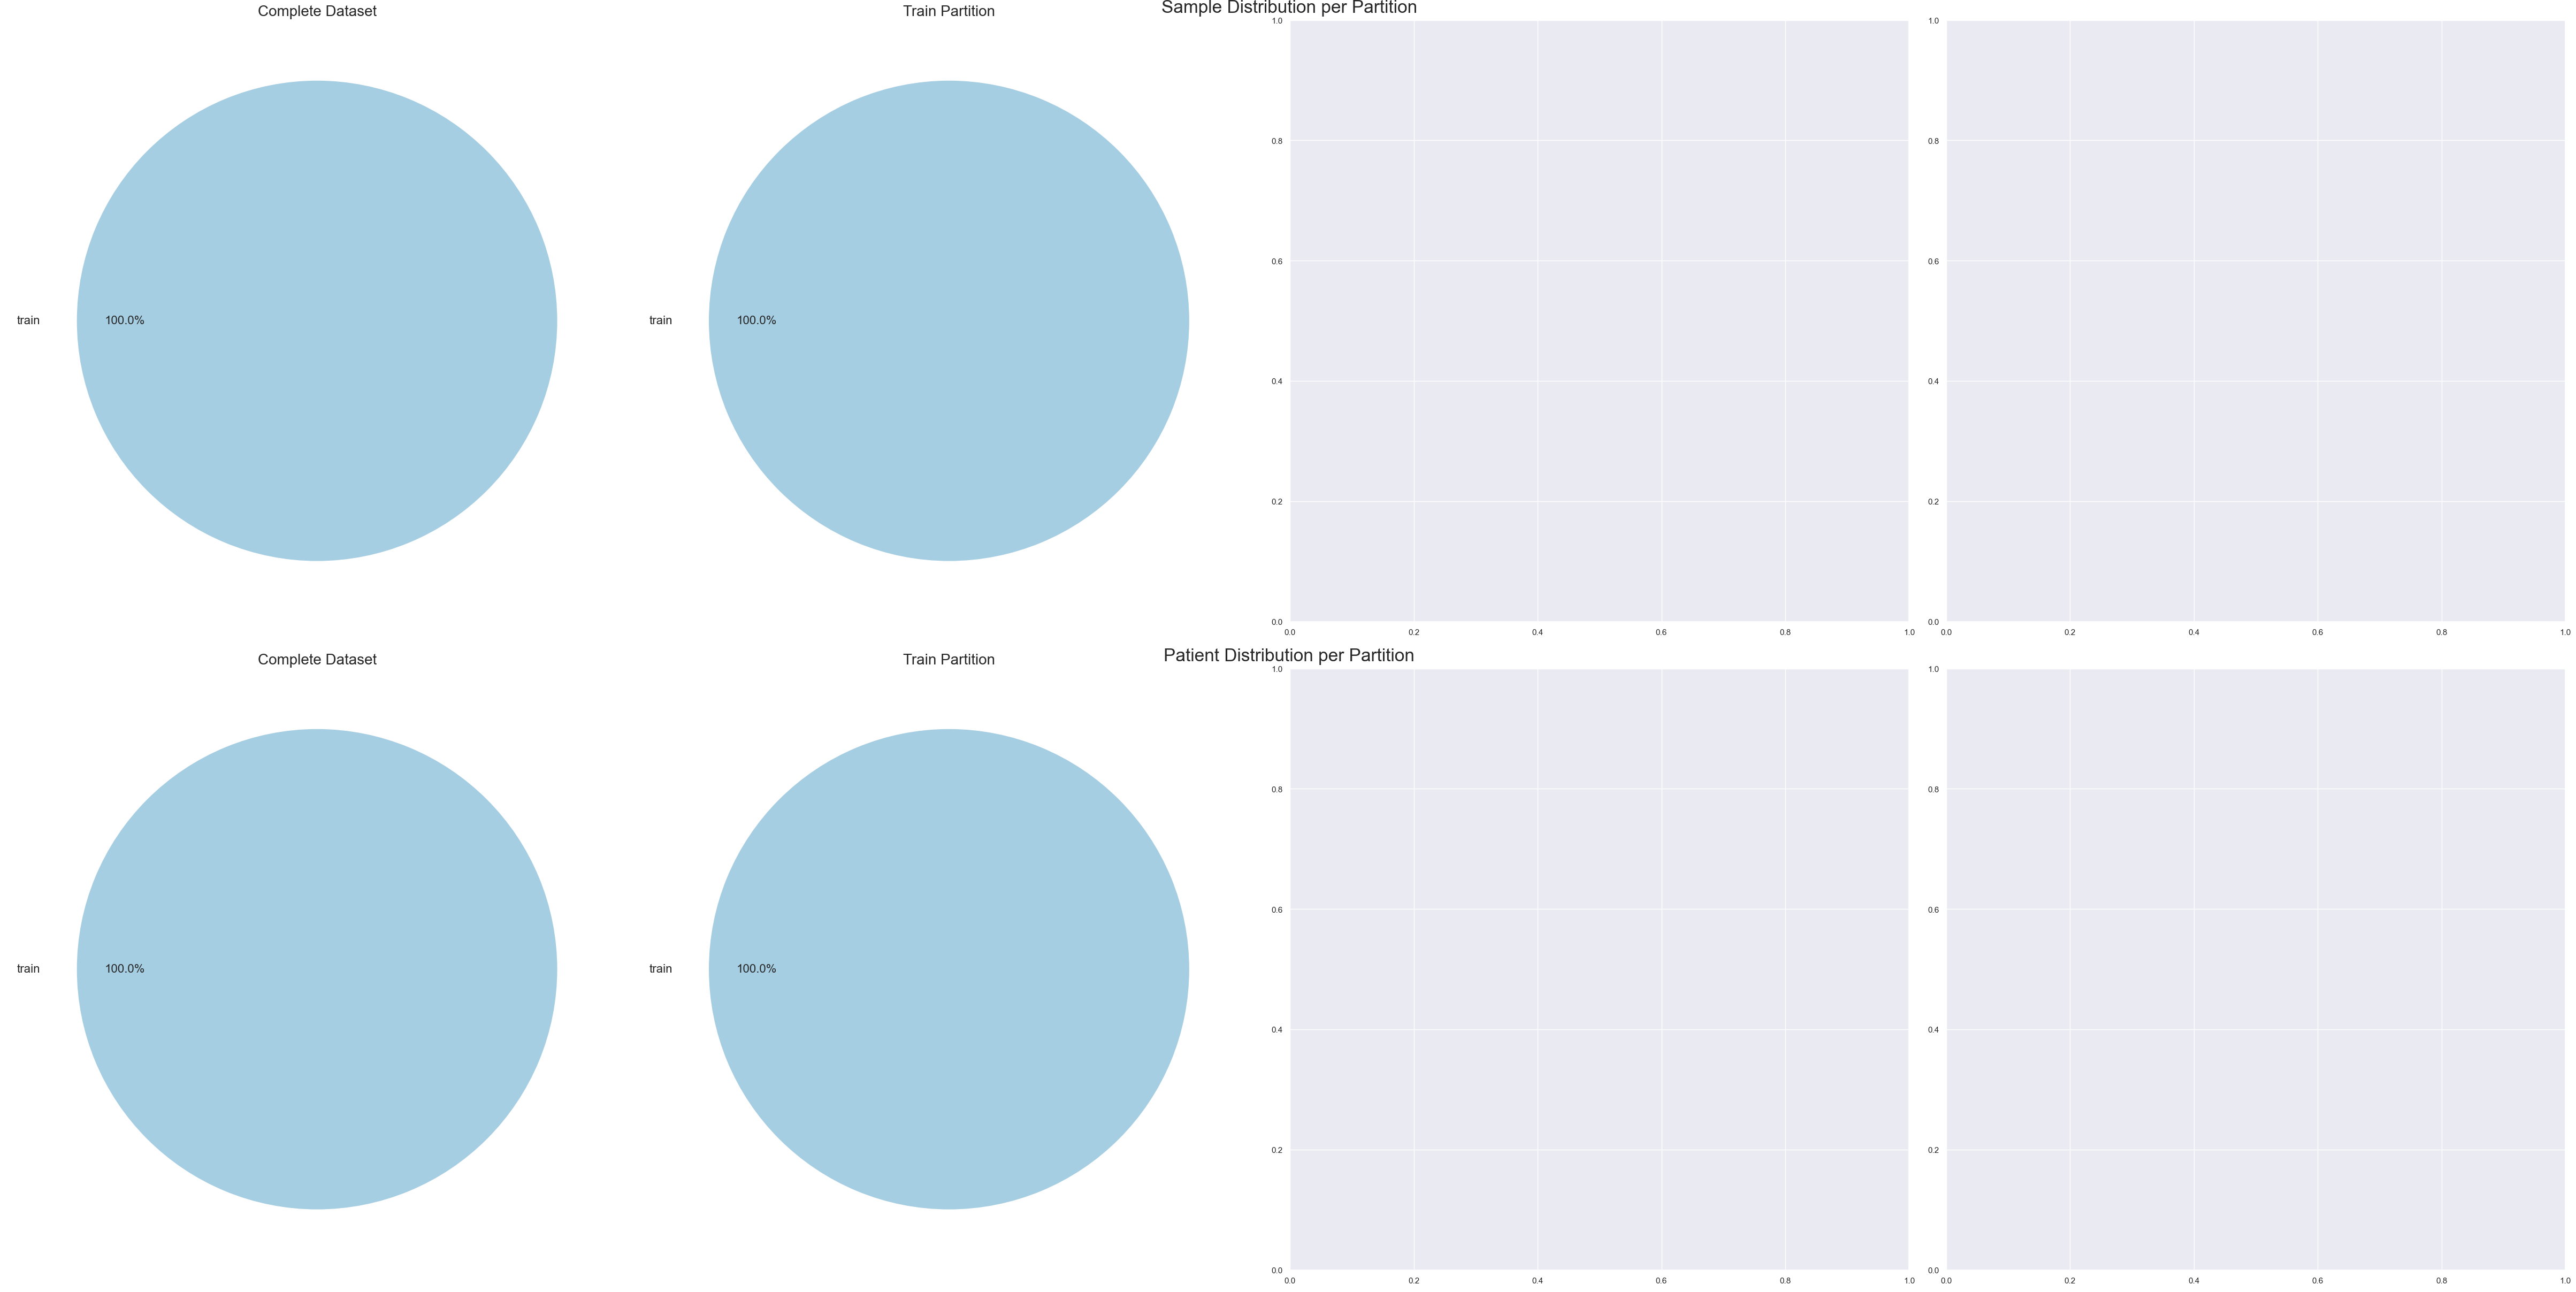

In [17]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [18]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

Sample Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 45912 
 45912 
 0 
 0 
 
 
 test 
 0 
 0 
 0 
 0 
 
 
 val 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 709 
 709 
 0 
 0 
 
 
 val 
 0 
 0 
 0 
 0 
 
 
 test 
 0 
 0 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

## Slice Selection

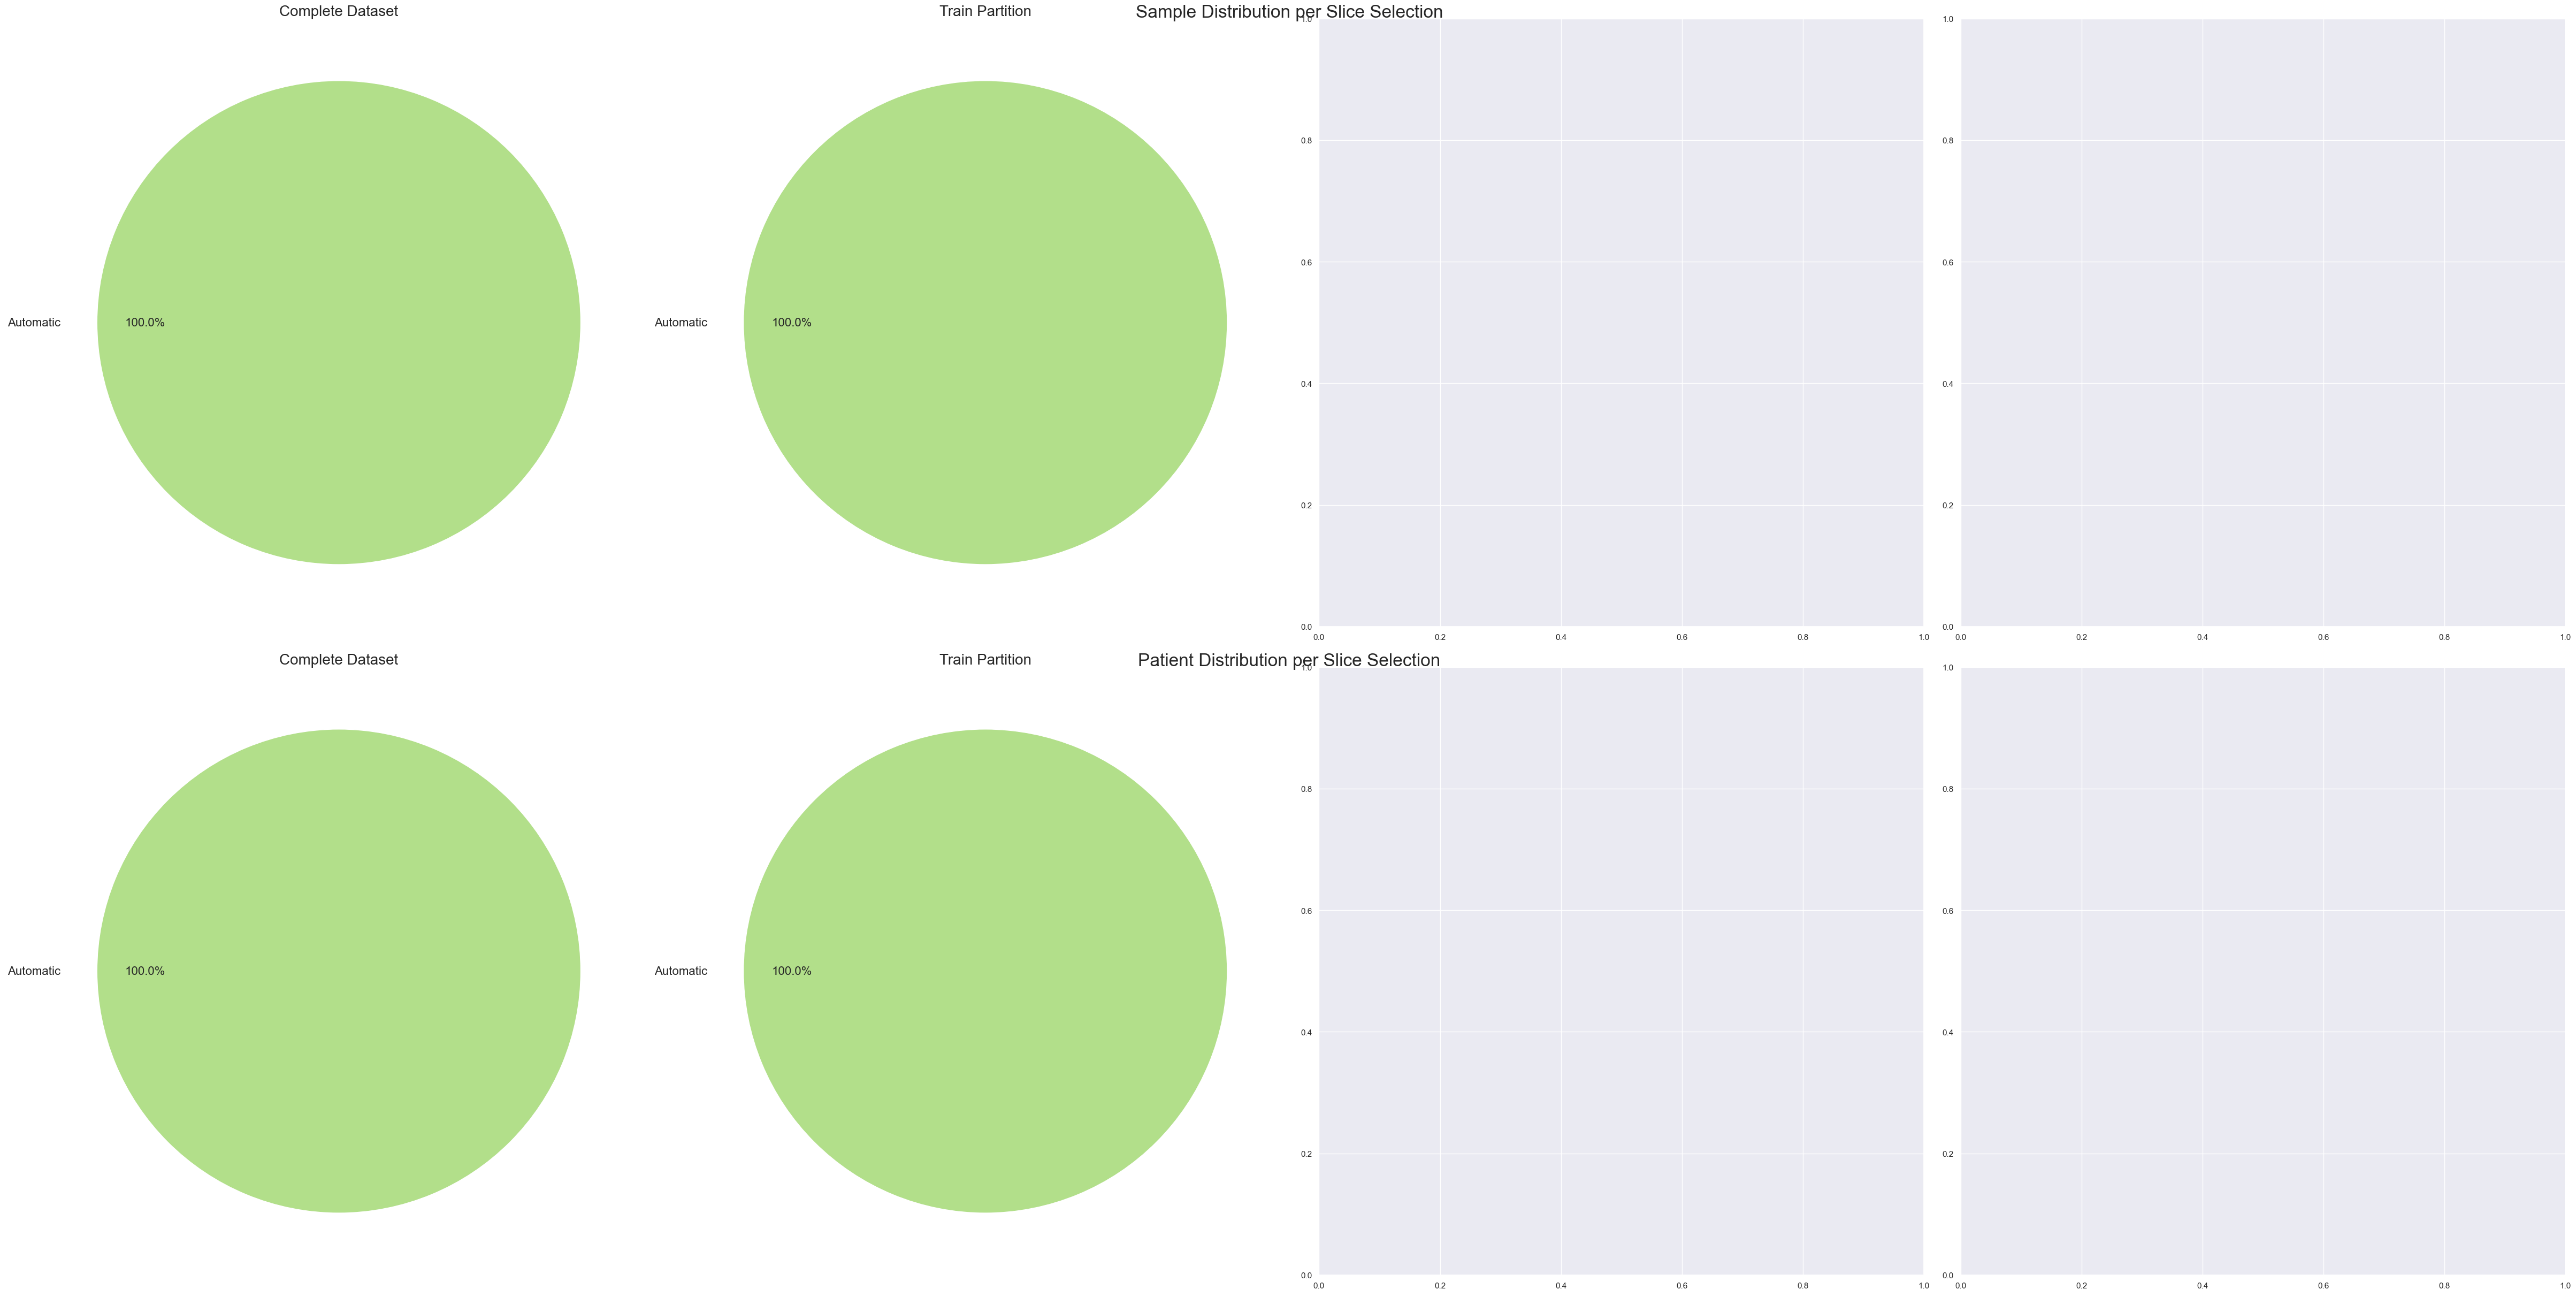

In [19]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [20]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

Sample Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Automatic 
 45912 
 45912 
 0 
 0 
 
 
 Expert 
 0 
 0 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Non-expert 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 Patient Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Automatic 
 709 
 709 
 0 
 0 
 
 
 Expert 
 0 
 0 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Non-expert 
 0 
 0 
 0 
 0 
 
 
 SUM 
 709 
 709 
 0 
 0

# Data Split

In [21]:
new_samples_df, new_patient_df = split.dataset_by_samples( samples_df, patient_df, dataset_name, seed = 1 )

    1/33: Group ('M', 'COVID-19', 'Automatic', 'China', (5, 10))
	[Test] Moved 0 samples (0 patients), expected 12 samples, had 61 samples (1 patients)...
		List of sample counts: [61]
	[Val] Moved 0 samples (0 patients), expected 12 samples, had 61 samples (1 patients)...
		List of sample counts: [61]



    2/33: Group ('M', 'COVID-19', 'Automatic', 'China', (10, 15))
	[Test] Moved 0 samples (0 patients), expected 0 samples, had 2 samples (1 patients)...
		List of sample counts: [2]
	[Val] Moved 0 samples (0 patients), expected 0 samples, had 2 samples (1 patients)...
		List of sample counts: [2]



    3/33: Group ('F', 'COVID-19', 'Automatic', 'China', (15, 20))
	[Test] Moved 0 samples (0 patients), expected 5 samples, had 28 samples (1 patients)...
		List of sample counts: [28]
	[Val] Moved 0 samples (0 patients), expected 5 samples, had 28 samples (1 patients)...
		List of sample counts: [28]



    4/33: Group ('M', 'COVID-19', 'Automatic', 'China', (20, 25))
	[Test] Moved 16 sa

# Post Split Plots

## Class

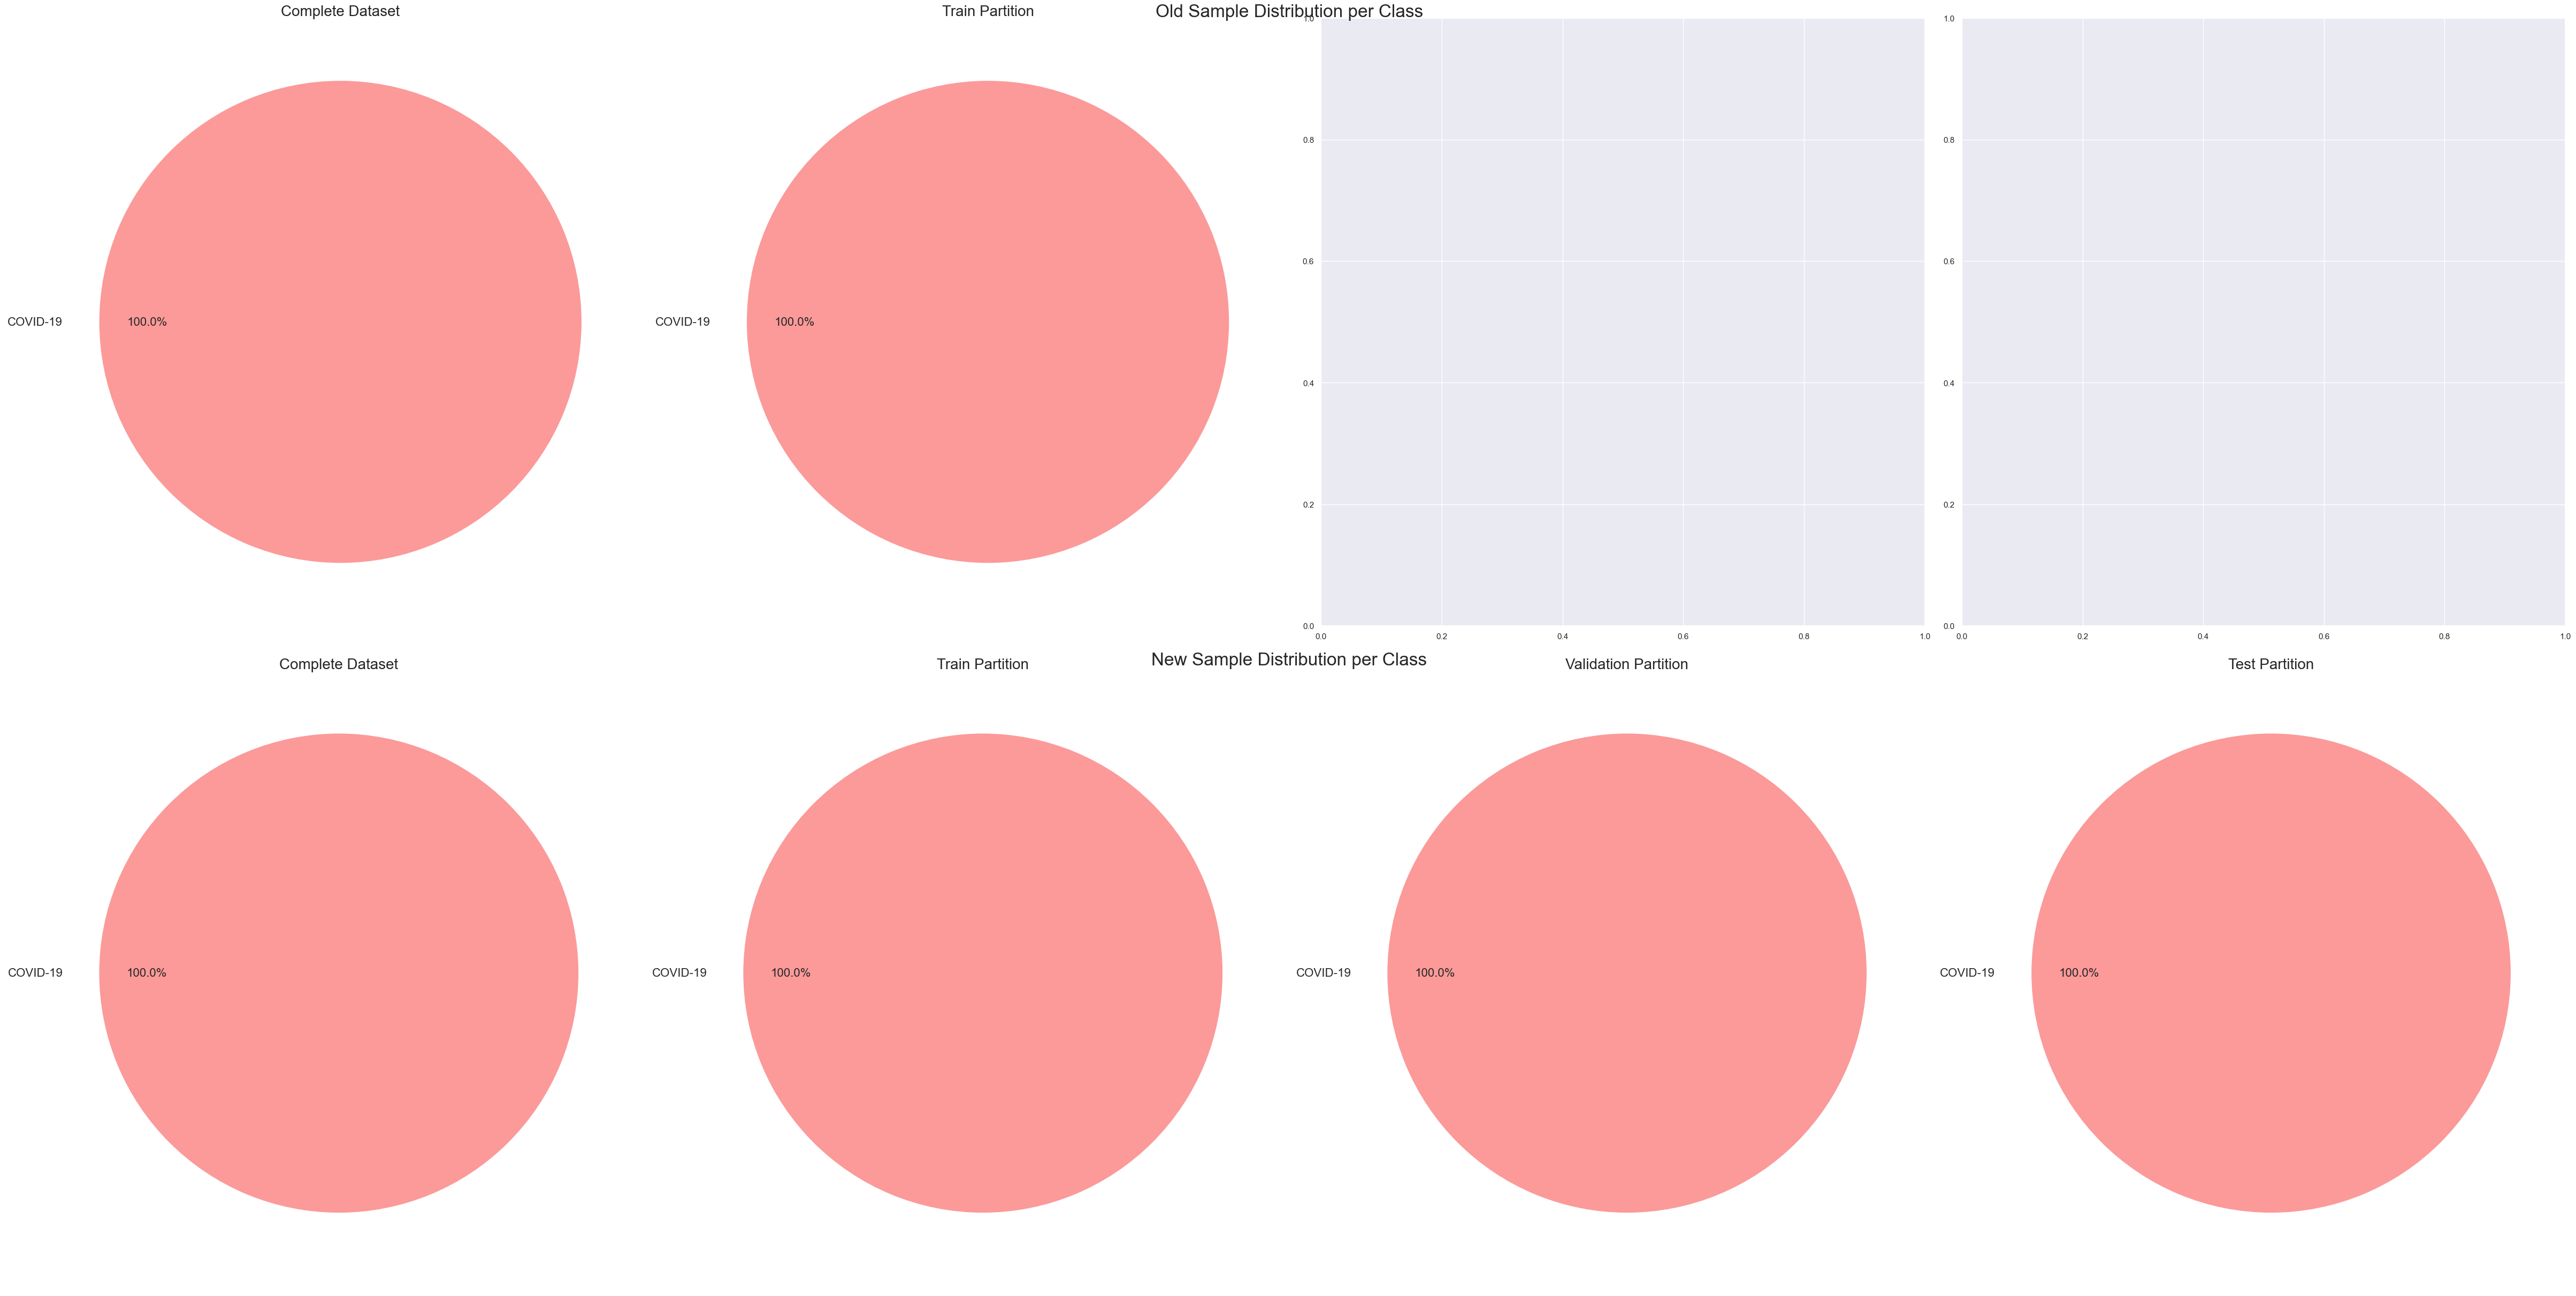

In [22]:
plot.column_as_pies( samples_df, new_samples_df, "class", dataset_name, figsize = (48, 24), resplit = True )

In [23]:
plot.column_as_table( samples_df, new_samples_df, "class", dataset_name, bin_flag = False, resplit = True )

Old Sample Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 45912 
 45912 
 0 
 0 
 
 
 Normal 
 0 
 0 
 0 
 0 
 
 
 Pneumonia 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 45912 
 28116 
 8847 
 8949 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

## Age

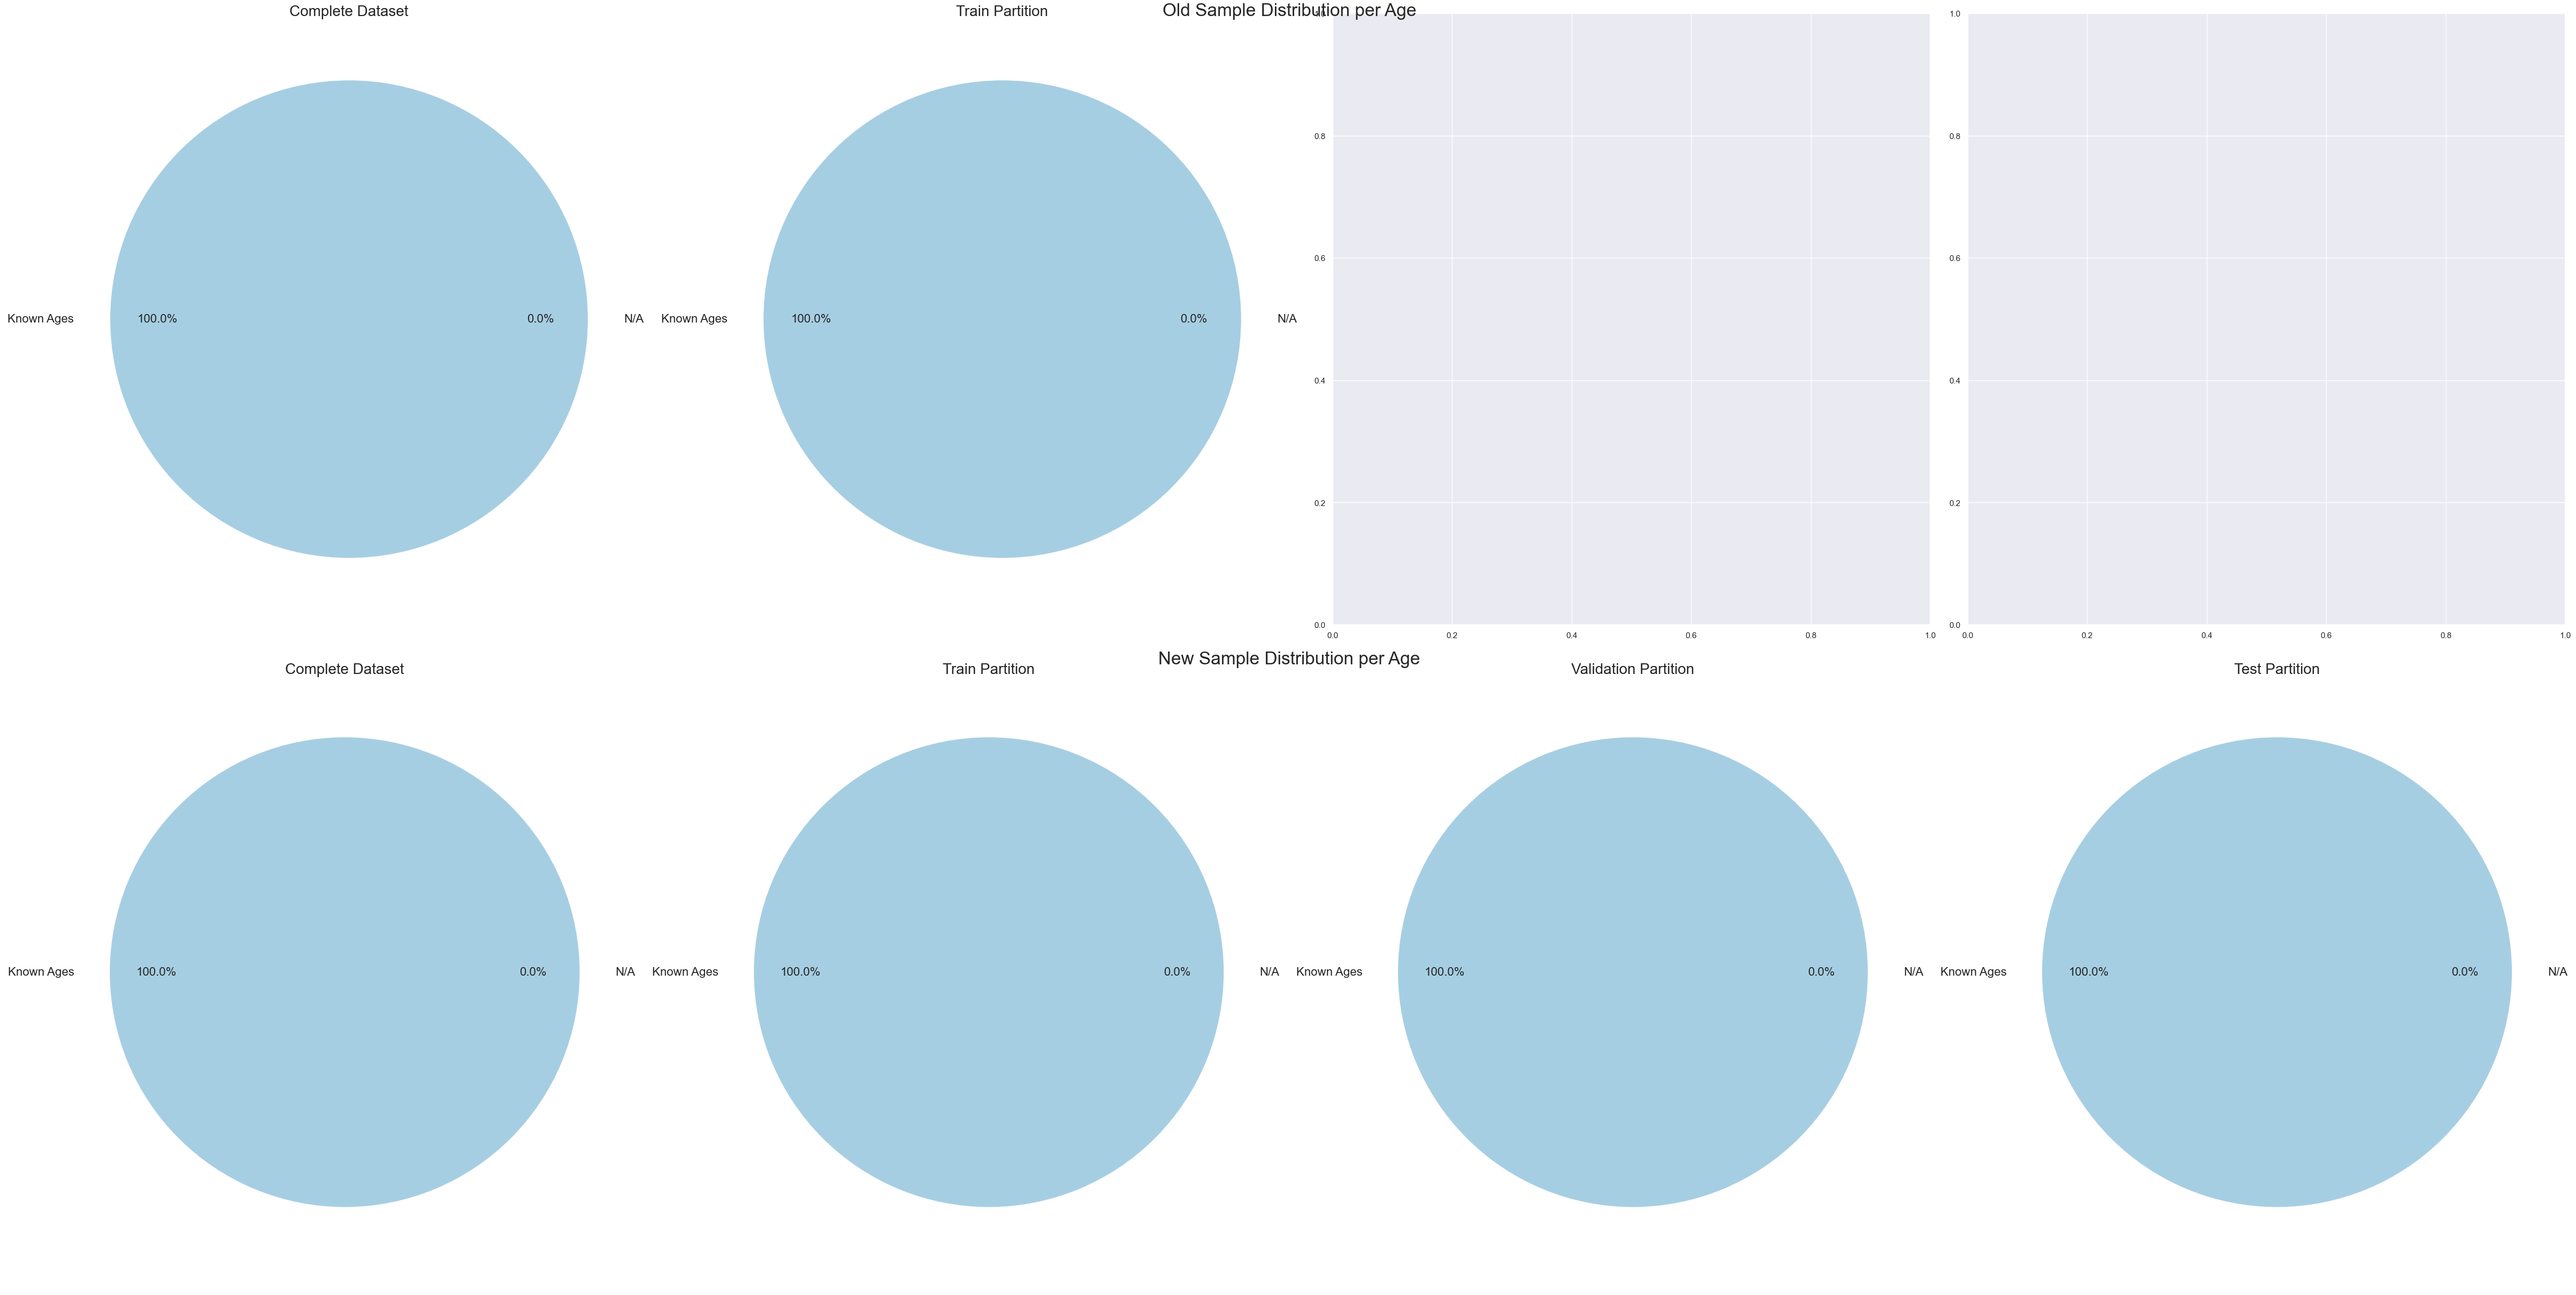

In [24]:
plot.column_as_pies( samples_df, new_samples_df, "age", dataset_name, figsize = (48, 24), resplit = True)

In [25]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = False, resplit = True )

Old Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Known Ages 
 45912 
 45912 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Known Ages 
 45912 
 28116 
 8847 
 8949 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

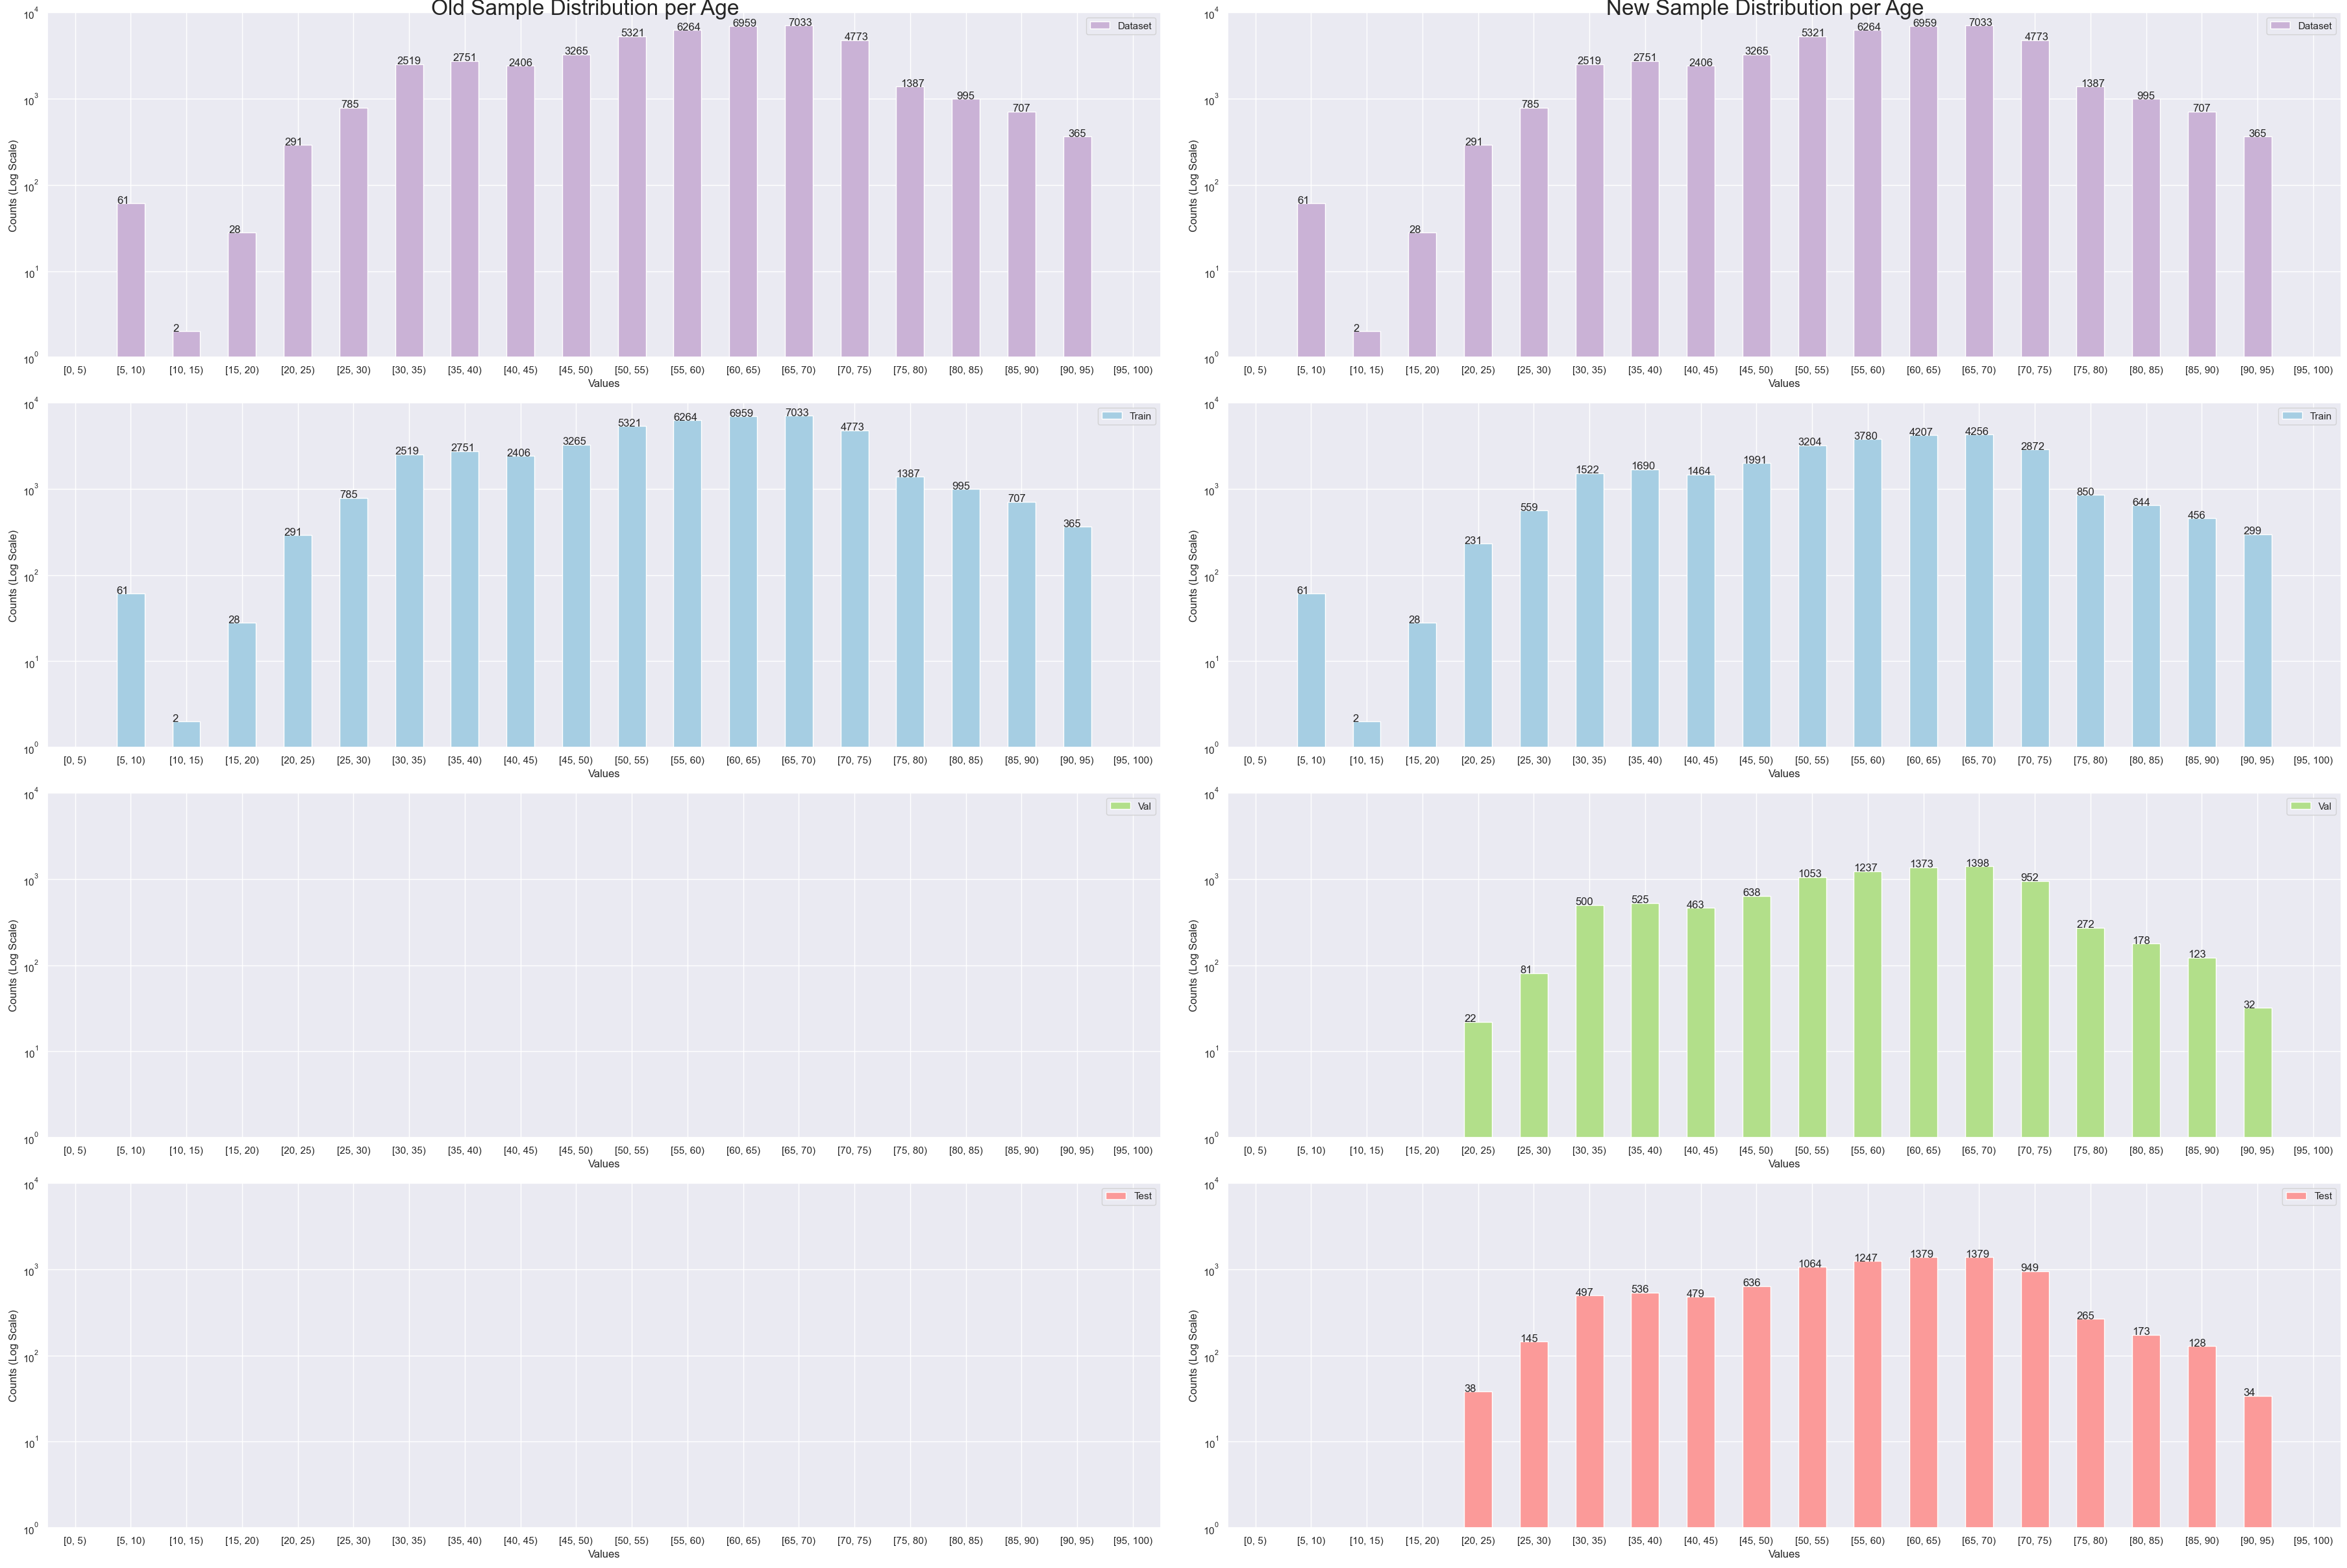

In [26]:
plot.column_as_histograms( samples_df, new_samples_df, "age", dataset_name, figsize = (36, 24), resplit = True)

In [27]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = True, resplit = True )

Old Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 0 
 0 
 0 
 0 
 
 
 [5, 10) 
 61 
 61 
 0 
 0 
 
 
 [10, 15) 
 2 
 2 
 0 
 0 
 
 
 [15, 20) 
 28 
 28 
 0 
 0 
 
 
 [20, 25) 
 291 
 291 
 0 
 0 
 
 
 [25, 30) 
 785 
 785 
 0 
 0 
 
 
 [30, 35) 
 2519 
 2519 
 0 
 0 
 
 
 [35, 40) 
 2751 
 2751 
 0 
 0 
 
 
 [40, 45) 
 2406 
 2406 
 0 
 0 
 
 
 [45, 50) 
 3265 
 3265 
 0 
 0 
 
 
 [50, 55) 
 5321 
 5321 
 0 
 0 
 
 
 [55, 60) 
 6264 
 6264 
 0 
 0 
 
 
 [60, 65) 
 6959 
 6959 
 0 
 0 
 
 
 [65, 70) 
 7033 
 7033 
 0 
 0 
 
 
 [70, 75) 
 4773 
 4773 
 0 
 0 
 
 
 [75, 80) 
 1387 
 1387 
 0 
 0 
 
 
 [80, 85) 
 995 
 995 
 0 
 0 
 
 
 [85, 90) 
 707 
 707 
 0 
 0 
 
 
 [90, 95) 
 365 
 365 
 0 
 0 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 0 
 0 
 0 
 0 
 
 
 [5, 10) 
 61 
 61 
 0 
 0 
 
 
 [10, 15) 
 2 
 2 
 0 
 0 
 
 
 [15, 20) 
 28 
 28 
 0 
 0 
 
 
 [20, 25) 
 291 
 231 
 22 
 38 
 
 
 [25, 30) 
 785 
 559 
 81 
 145 
 
 
 [30, 35) 
 2519 
 1522 
 500 
 497 
 
 
 [35, 40) 
 2751 
 1690 
 525 
 536 
 
 
 [40, 45) 
 2406 
 1464 
 463 
 479 
 
 
 [45, 50) 
 3265 
 1991 
 638 
 636 
 
 
 [50, 55) 
 5321 
 3204 
 1053 
 1064 
 
 
 [55, 60) 
 6264 
 3780 
 1237 
 1247 
 
 
 [60, 65) 
 6959 
 4207 
 1373 
 1379 
 
 
 [65, 70) 
 7033 
 4256 
 1398 
 1379 
 
 
 [70, 75) 
 4773 
 2872 
 952 
 949 
 
 
 [75, 80) 
 1387 
 850 
 272 
 265 
 
 
 [80, 85) 
 995 
 644 
 178 
 173 
 
 
 [85, 90) 
 707 
 456 
 123 
 128 
 
 
 [90, 95) 
 365 
 299 
 32 
 34 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

## Sex

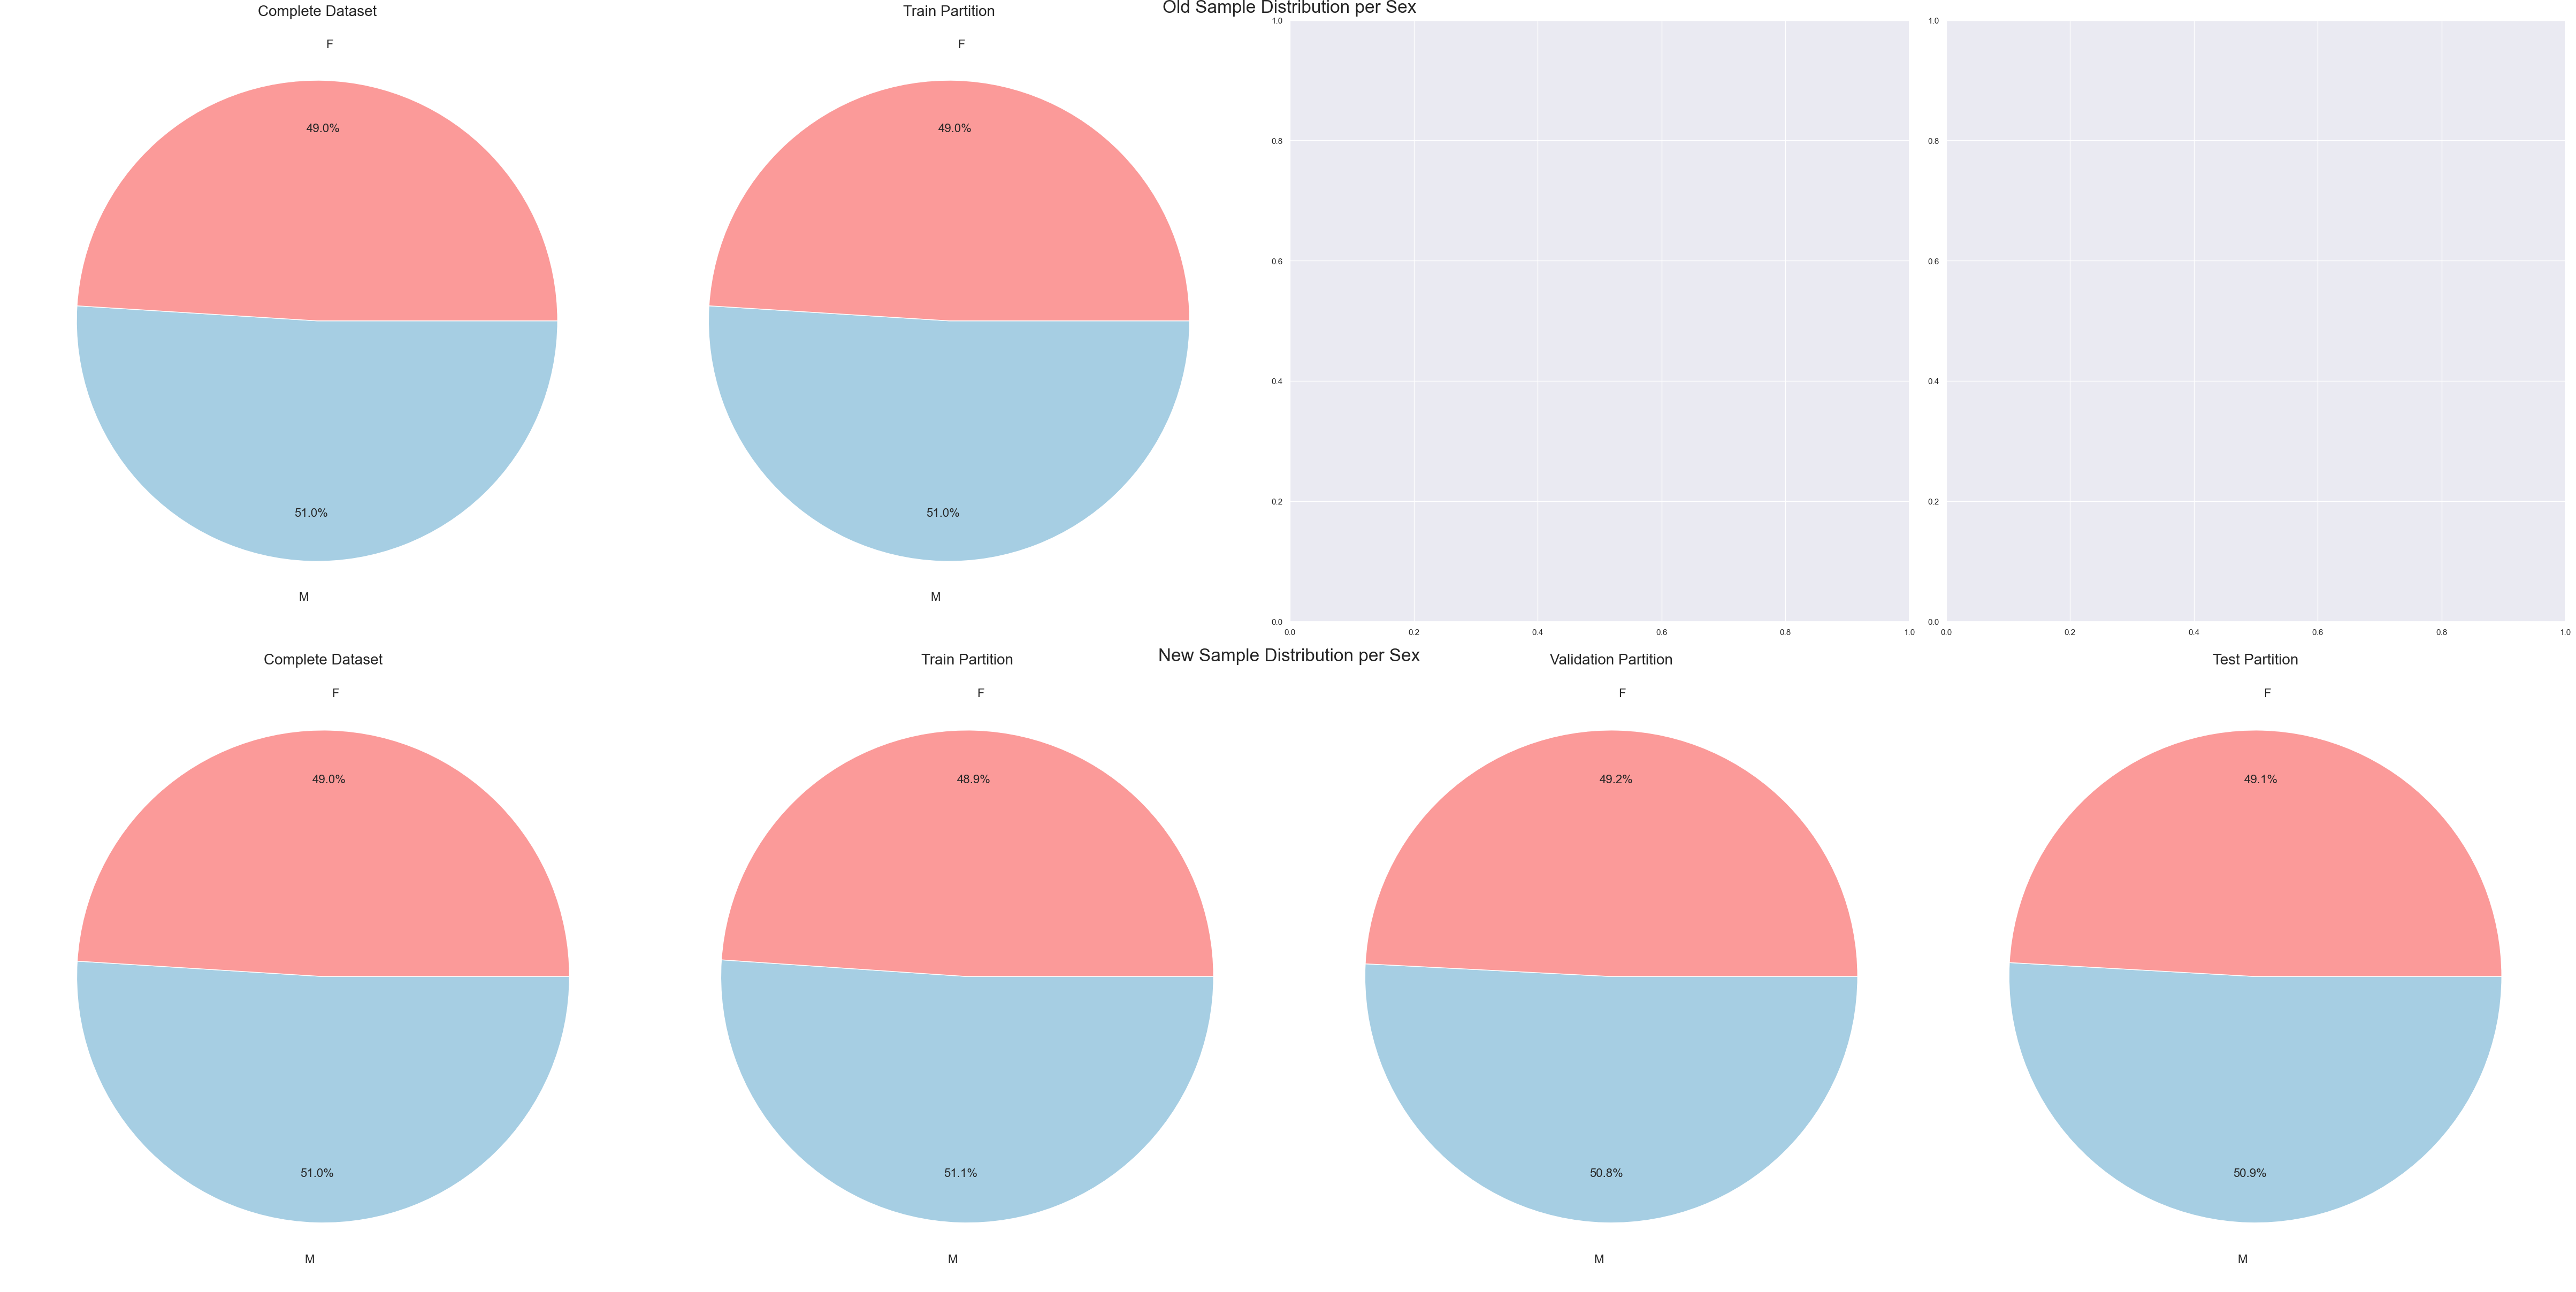

In [28]:
plot.column_as_pies( samples_df, new_samples_df, "sex", dataset_name, figsize = (48, 24), resplit = True )

In [29]:
plot.column_as_table( samples_df, new_samples_df, "sex", dataset_name, bin_flag = False, resplit = True )

Old Sample Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 M 
 23412 
 23412 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 F 
 22500 
 22500 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 M 
 23412 
 14361 
 4496 
 4555 
 
 
 F 
 22500 
 13755 
 4351 
 4394 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

## Country

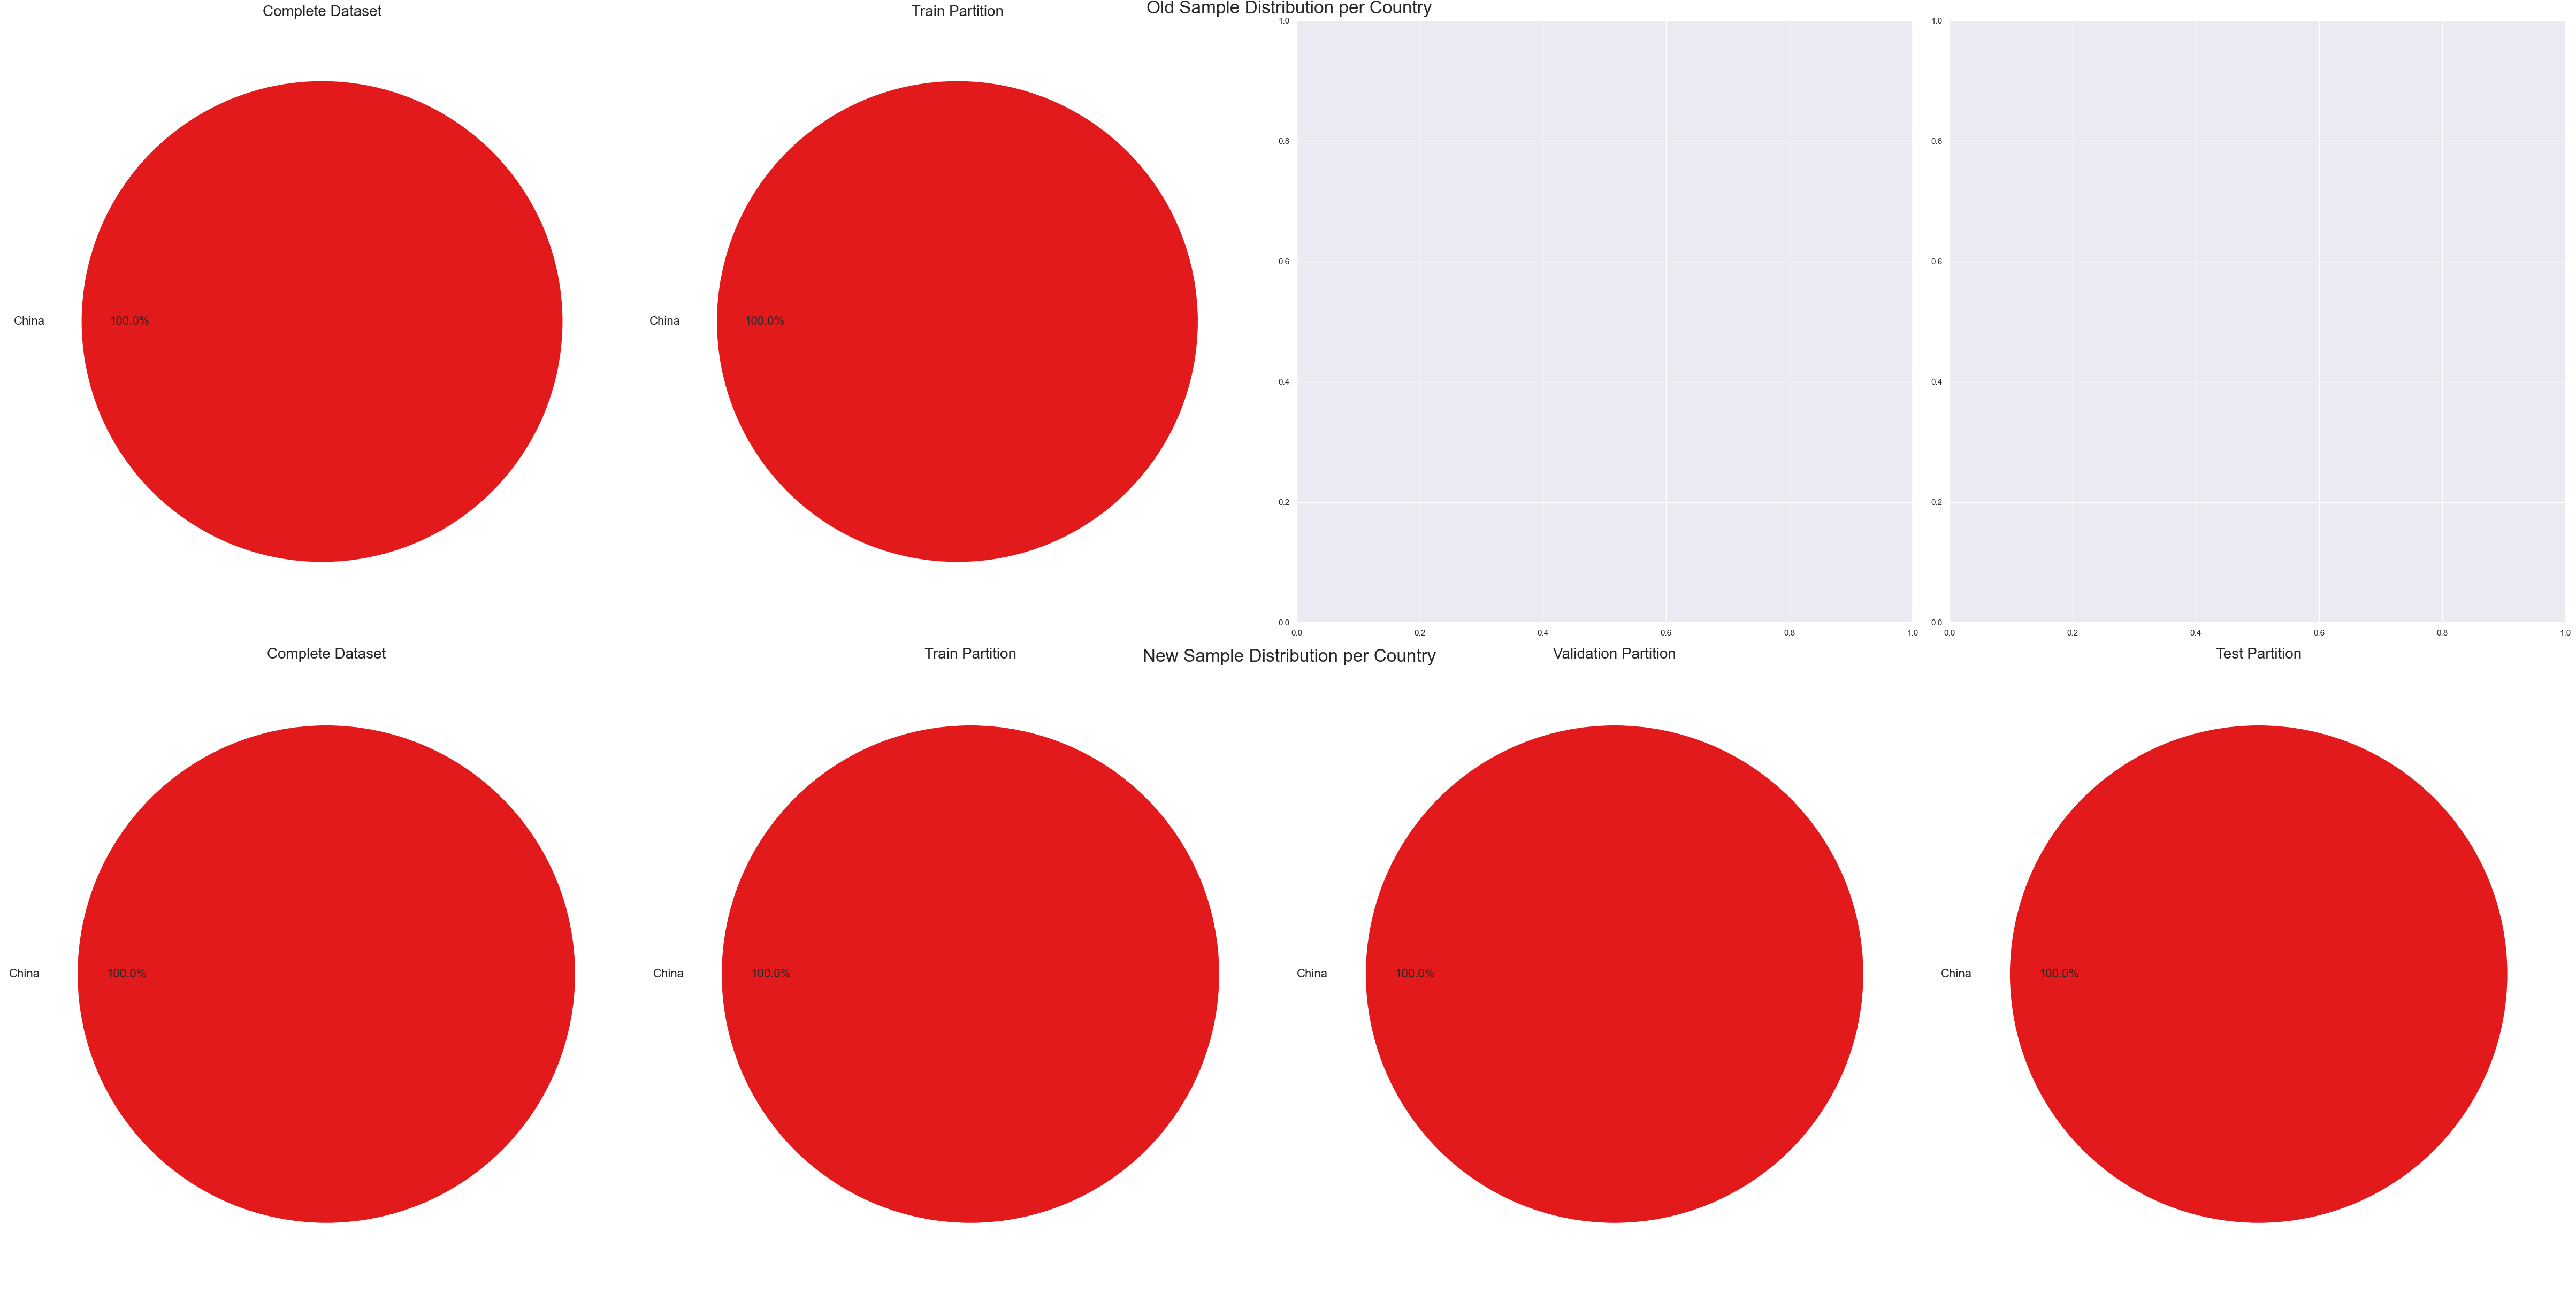

In [30]:
plot.column_as_pies( samples_df, new_samples_df, "country", dataset_name, figsize = (48, 24), resplit = True )

In [31]:
plot.column_as_table( samples_df, new_samples_df, "country", dataset_name, bin_flag = False, resplit = True )

Old Sample Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 France 
 0 
 0 
 0 
 0 
 
 
 China 
 45912 
 45912 
 0 
 0 
 
 
 Iran 
 0 
 0 
 0 
 0 
 
 
 USA 
 0 
 0 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Australia 
 0 
 0 
 0 
 0 
 
 
 Italy 
 0 
 0 
 0 
 0 
 
 
 Algeria 
 0 
 0 
 0 
 0 
 
 
 Belgium 
 0 
 0 
 0 
 0 
 
 
 England 
 0 
 0 
 0 
 0 
 
 
 Scotland 
 0 
 0 
 0 
 0 
 
 
 Turkey 
 0 
 0 
 0 
 0 
 
 
 Azerbaijan 
 0 
 0 
 0 
 0 
 
 
 Lebanon 
 0 
 0 
 0 
 0 
 
 
 Ukraine 
 0 
 0 
 0 
 0 
 
 
 Afghanistan 
 0 
 0 
 0 
 0 
 
 
 Peru 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 45912 
 28116 
 8847 
 8949 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

## Partition

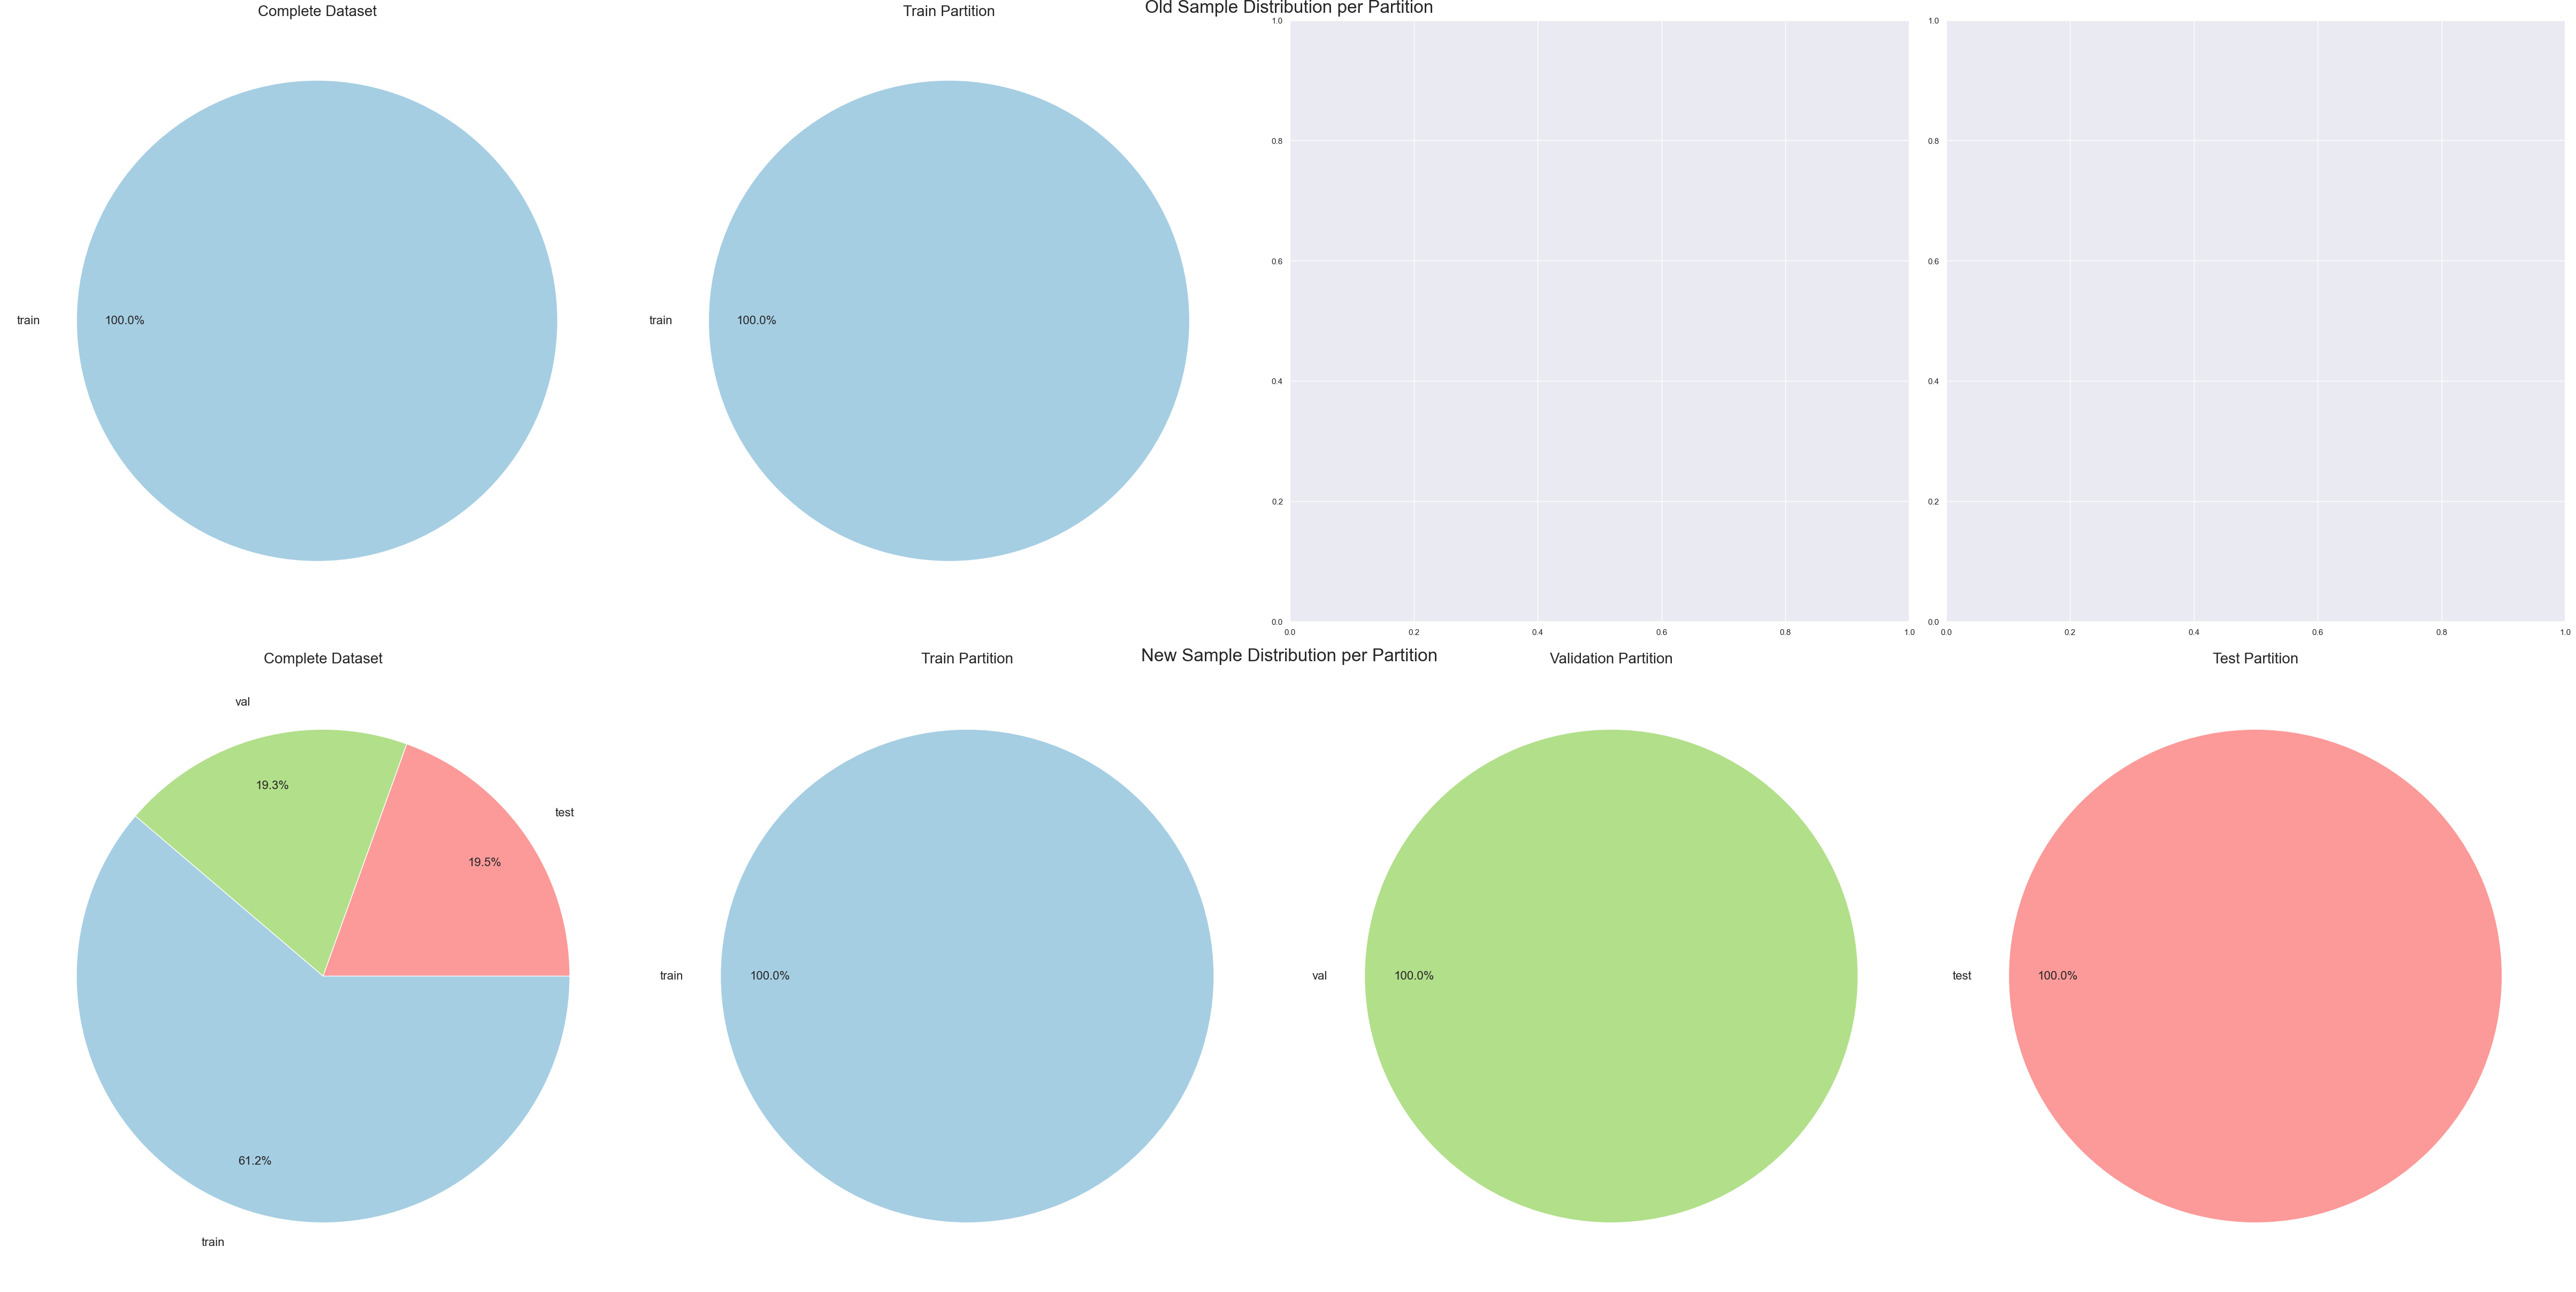

In [32]:
plot.column_as_pies( samples_df, new_samples_df, "partition", dataset_name, figsize = (48, 24), resplit = True )

In [33]:
plot.column_as_table( samples_df, new_samples_df, "partition", dataset_name, bin_flag = False, resplit = True )

Old Sample Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 45912 
 45912 
 0 
 0 
 
 
 test 
 0 
 0 
 0 
 0 
 
 
 val 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 28116 
 28116 
 0 
 0 
 
 
 test 
 8949 
 0 
 0 
 8949 
 
 
 val 
 8847 
 0 
 8847 
 0 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

## Slice Selection

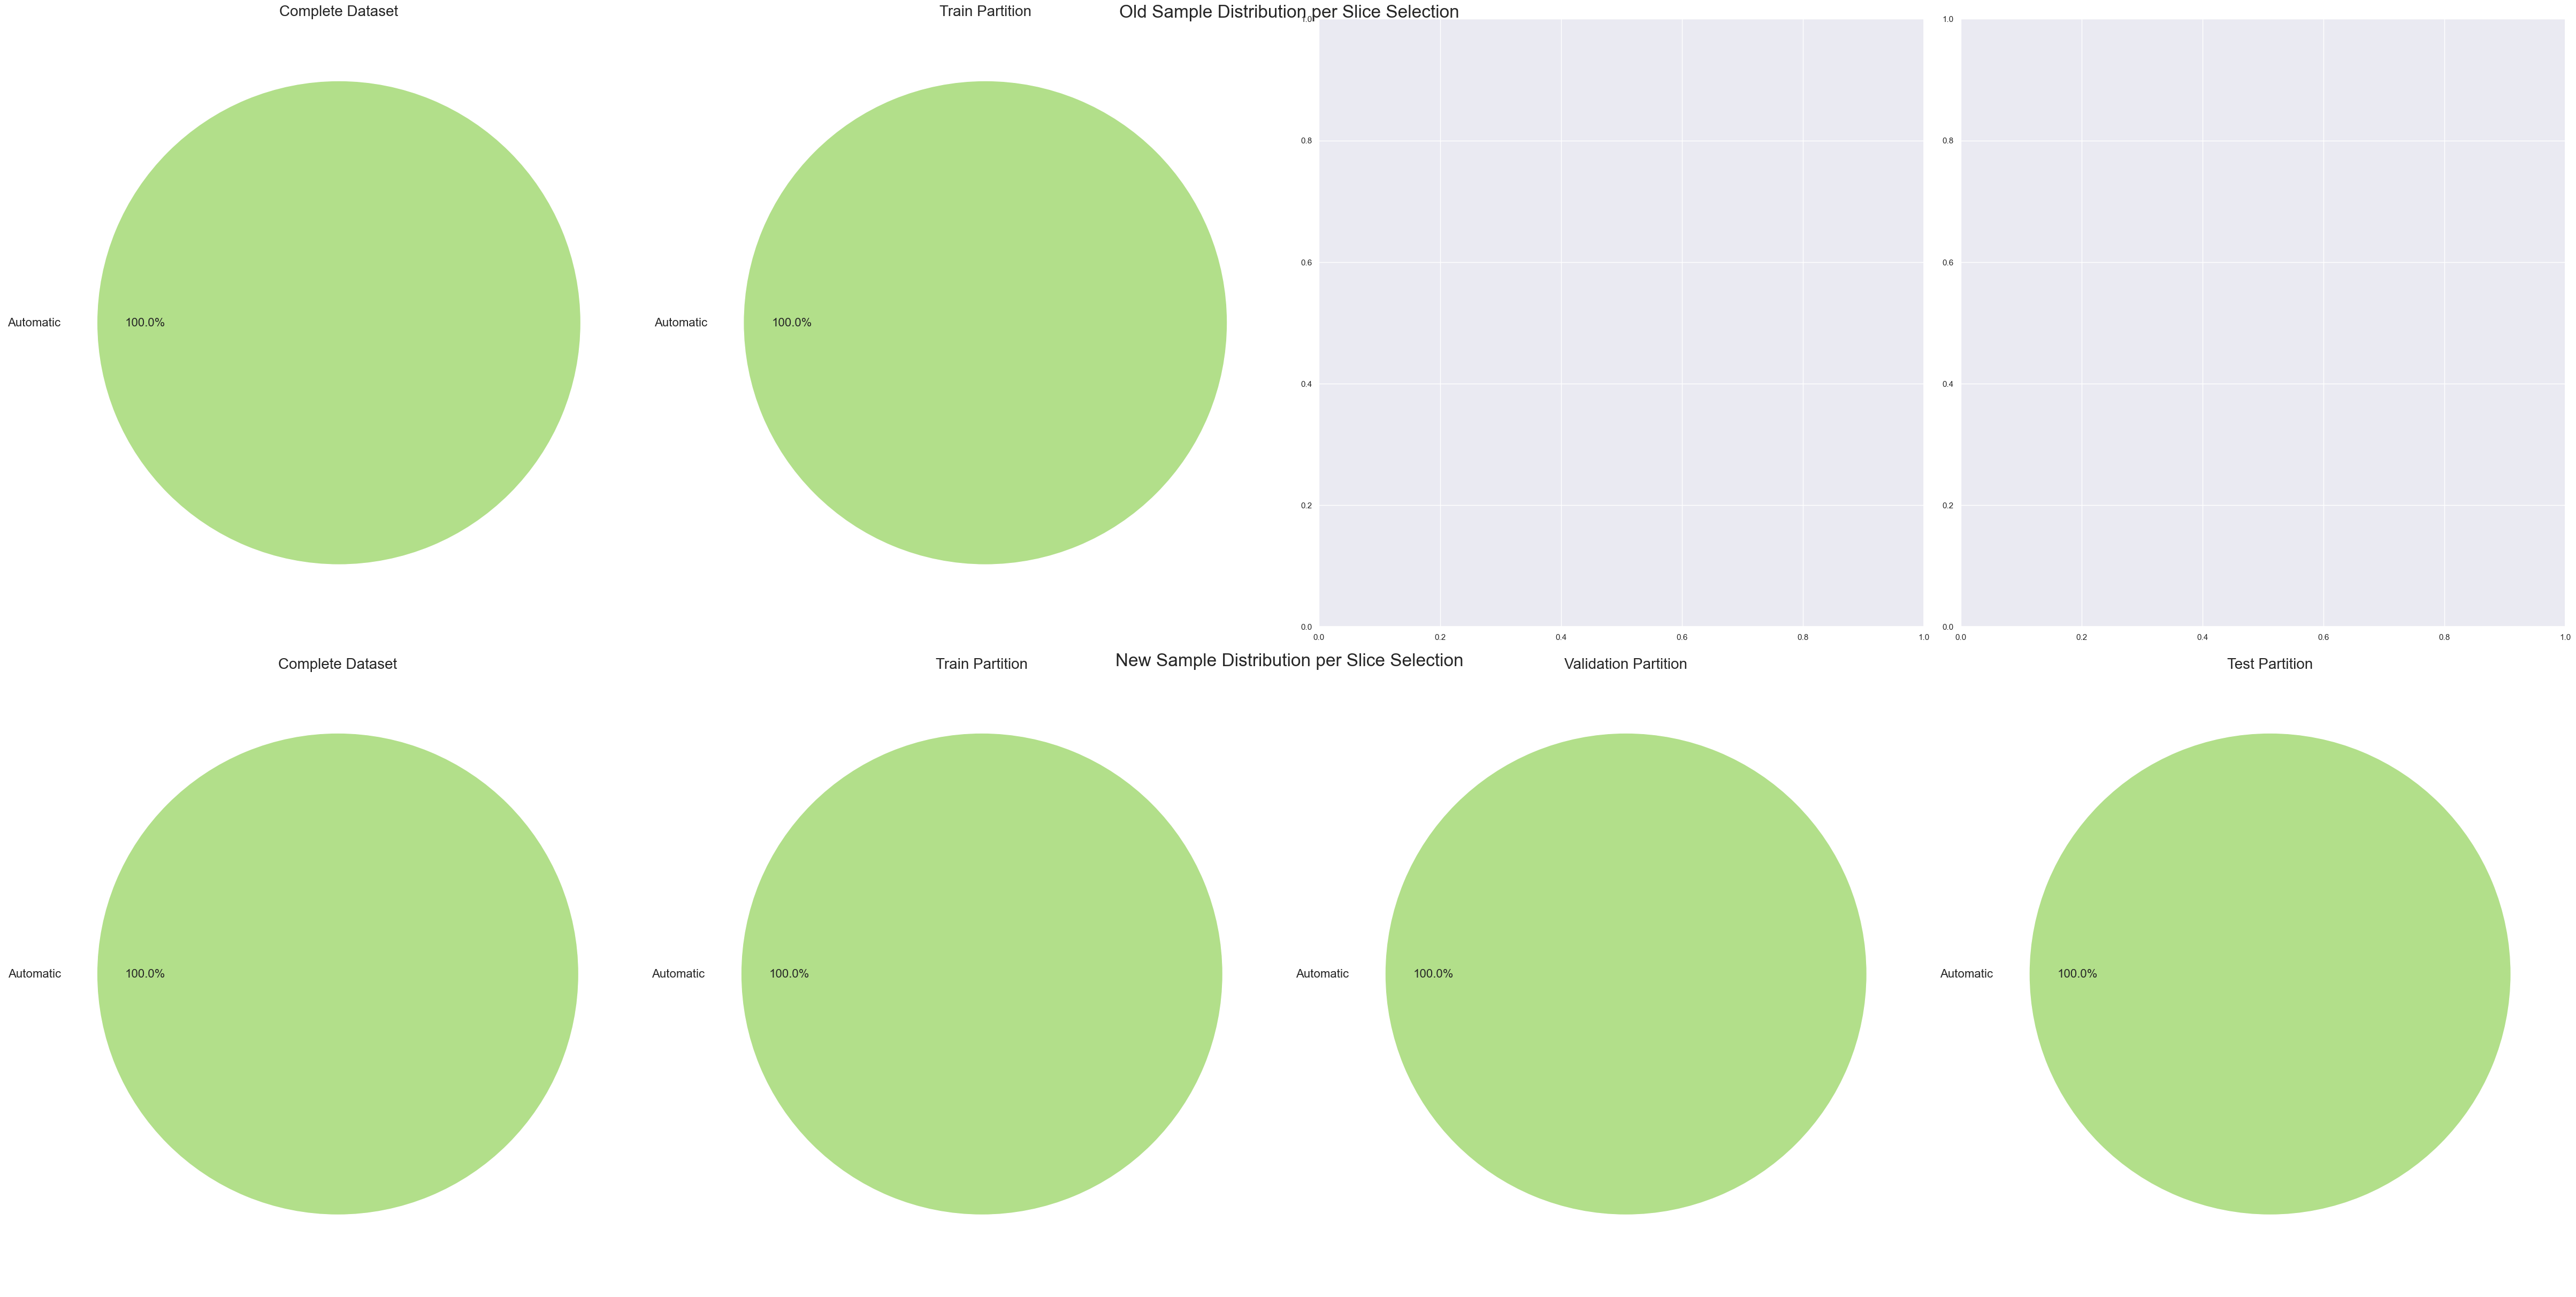

In [34]:
plot.column_as_pies( samples_df, new_samples_df, "slice_selection", dataset_name, figsize = (48, 24), resplit = True )

In [35]:
plot.column_as_table( samples_df, new_samples_df, "slice_selection", dataset_name, bin_flag = False, resplit = True )

Old Sample Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Automatic 
 45912 
 45912 
 0 
 0 
 
 
 Expert 
 0 
 0 
 0 
 0 
 
 
 N/A 
 0 
 0 
 0 
 0 
 
 
 Non-expert 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 45912 
 0 
 0 
 
 
 New Sample Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Automatic 
 45912 
 28116 
 8847 
 8949 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949

# Registering Changes

In [36]:
# Path to save new metadata csv
csv_export_path = os.path.join( data_dir, "new_split_metadata.csv" )

updated_df = split.update_metadata_csv( csv_export_path, new_samples_df, dataset_name, save_bool = True )
print( len(updated_df), len(new_samples_df) )
updated_df.head()

177381 45912


filename patient_id source     class country sex   age  \
0  NCP_96_1328_0032.png     NCP_96   CNCB  COVID-19   China   M  74.0   
1  NCP_96_1328_0035.png     NCP_96   CNCB  COVID-19   China   M  74.0   
2  NCP_96_1328_0036.png     NCP_96   CNCB  COVID-19   China   M  74.0   
3  NCP_96_1328_0037.png     NCP_96   CNCB  COVID-19   China   M  74.0   
4  NCP_96_1328_0038.png     NCP_96   CNCB  COVID-19   China   M  74.0   

  partition slice_selection  x_min  y_min  x_max  y_max verified_finding  \
0     train          Expert      9     94    512    405              Yes   
1     train          Expert     10    106    512    405              Yes   
2     train          Expert     10    105    512    406              Yes   
3     train          Expert     11    104    512    406              Yes   
4     train          Expert     11    103    512    406              Yes   

    view modality  
0  Axial       CT  
1  Axial       CT  
2  Axial       CT  
3  Axial       CT  
4  Axial       CT